# Reproducibility Analysis: Cross-Experimental Comparison

## Overview
This notebook performs reproducibility analysis across different experimental conditions and genotypes. It processes RNA-seq data from multiple experiments, performs gene expression correlation analysis, and evaluates the consistency of results across biological replicates and experimental conditions.

## Analysis Workflow
1. **Data Collection**: Process STAR mapping results from multiple experiments
2. **Gene Annotation**: Map Ensembl IDs to gene symbols using GTF annotations
3. **Data Aggregation**: Combine expression data across all samples
4. **Quality Control**: Calculate expression statistics and identify variable genes
5. **Correlation Analysis**: Assess sample correlations and clustering patterns
6. **Reproducibility Metrics**: Evaluate consistency across replicates and conditions

## Input Files
- Multiple experiment directories containing STAR mapping results
- GTF annotation file for gene ID mapping
- STAR output files: `*_STAR_ReadsPerGene.out.tab`

## Output Files
- `bulk/reproducibility_genotypes.tsv`: Combined expression matrix
- `bulk/reproducibility_genotypes_meta.tsv`: Sample metadata
- Correlation plots and clustering visualizations

## Requirements
- pandas, numpy, seaborn, matplotlib
- Access to GTF annotation file
- STAR mapping results from reproducibility experiments

## Configuration and Setup

In [ ]:
# =============================================================================
# CONFIGURATION AND PARAMETERS
# =============================================================================

import os
import re
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# File paths and directories
GTF_FILE_PATH = "/links/groups/treutlein/USERS/jjans/resources/genomes/hsapiens/Homo_sapiens.GRCh38.111.chr.gtf"
OUTPUT_DIR = "bulk"
EXPERIMENT_PATTERN = "Reproducibility"  # Pattern to identify experiment directories

# Analysis parameters
N_VARIABLE_GENES = 1000  # Number of top variable genes for analysis
CPM_SCALING_FACTOR = 1e6  # Scaling factor for CPM calculation
SKIP_ROWS = 4  # Rows to skip in STAR output files

# Plot parameters
FIGURE_SIZE = (30, 30)  # Size for correlation heatmaps
DPI = 300

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration loaded successfully!")
print(f"GTF file path: {GTF_FILE_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Looking for experiments matching: {EXPERIMENT_PATTERN}")
print(f"Variable genes to analyze: {N_VARIABLE_GENES}")

In [ ]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Core data analysis
import pandas as pd
import numpy as np
import os
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
print(f"Seaborn version: {sns.__version__}")

## 1. Gene Annotation Loading

In [ ]:
# =============================================================================
# GTF ANNOTATION LOADING
# =============================================================================

def load_gtf_annotation(gtf_file_path):
    """
    Load gene ID to gene name mapping from GTF file.
    
    Parameters:
        gtf_file_path (str): Path to GTF annotation file
        
    Returns:
        dict: Mapping from Ensembl gene IDs to gene symbols
    """
    print(f"Loading GTF annotation from: {gtf_file_path}")
    
    try:
        with open(gtf_file_path) as f:
            gtf_lines = list(f)
        
        # Filter lines containing gene information
        gtf_lines = [x for x in gtf_lines if not x.startswith('#')]
        gtf_lines = [x for x in gtf_lines if 'gene_id "' in x and 'gene_name "' in x]
        
        if len(gtf_lines) == 0:
            raise ValueError('No gene annotations found. Check GTF file format.')
        
        # Extract gene ID and gene name pairs
        gene_mappings = []
        for line in gtf_lines:
            gene_id = line.split('gene_id "')[1].split('"')[0]
            gene_name = line.split('gene_name "')[1].split('"')[0]
            gene_mappings.append((gene_id, gene_name))
        
        # Create dictionary and remove duplicates
        gtf_dict = dict(set(gene_mappings))
        
        print(f"✓ Loaded {len(gtf_dict)} gene annotations")
        return gtf_dict
        
    except FileNotFoundError:
        print(f"✗ GTF file not found: {gtf_file_path}")
        raise
    except Exception as e:
        print(f"✗ Error loading GTF file: {e}")
        raise

# Load gene annotation dictionary
print("Loading gene annotation mapping...")
gtf_dict = load_gtf_annotation(GTF_FILE_PATH)

## 2. Experiment Discovery and Data Collection

In [ ]:
# =============================================================================
# EXPERIMENT DISCOVERY AND DATA COLLECTION
# =============================================================================

def discover_experiments(pattern=EXPERIMENT_PATTERN):
    """
    Discover experiment directories matching the specified pattern.
    
    Parameters:
        pattern (str): Pattern to match in directory names
        
    Returns:
        list: List of experiment directory names
    """
    experiments = [x for x in os.listdir() if pattern in x]
    print(f"Found {len(experiments)} experiments matching '{pattern}':")
    for exp in experiments:
        print(f"  - {exp}")
    return experiments

def load_star_data(experiments, gtf_dict):
    """
    Load and process STAR mapping results from all experiments.
    
    Parameters:
        experiments (list): List of experiment directories
        gtf_dict (dict): Gene ID to symbol mapping
        
    Returns:
        pandas.DataFrame: Combined expression matrix
    """
    print("Loading STAR mapping results...")
    df_all = None
    sample_count = 0
    
    for exp_dir in experiments:
        print(f"Processing experiment: {exp_dir}")
        
        try:
            exp_samples = os.listdir(exp_dir)
            
            for sample in exp_samples:
                star_file = os.path.join(exp_dir, sample, "10.MAPPING", f"{sample}_STAR_ReadsPerGene.out.tab")
                
                if os.path.exists(star_file):
                    print(f"  Loading: {star_file}")
                    
                    # Load STAR output
                    df_sample = pd.read_csv(star_file, sep="\t", skiprows=SKIP_ROWS, header=None)
                    df_sample.columns = ['Gene_ID', 'Unstranded', '1st_read', '2nd_read']
                    
                    # Map gene IDs to symbols
                    df_sample['Gene_Symbol'] = [
                        gtf_dict.get(gene_id, gene_id) for gene_id in df_sample['Gene_ID']
                    ]
                    df_sample.index = df_sample['Gene_Symbol']
                    
                    # Initialize or add to combined dataframe
                    if df_all is None:
                        df_all = pd.DataFrame(index=df_sample.index)
                    
                    df_all[sample] = df_sample['Unstranded']
                    sample_count += 1
                    
                else:
                    print(f"  ⚠ STAR file not found: {star_file}")
                    
        except Exception as e:
            print(f"  ✗ Error processing {exp_dir}: {e}")
    
    print(f"✓ Loaded data from {sample_count} samples")
    return df_all

# Discover experiments and load data
reproducibility_experiments = discover_experiments()
print()

# Load and combine all STAR data
df_all = load_star_data(reproducibility_experiments, gtf_dict)

## 3. Data Processing and Quality Control

In [ ]:
# =============================================================================
# DATA PROCESSING AND NORMALIZATION
# =============================================================================

print("Processing and normalizing expression data...")

# Group genes by symbol and sum counts (handles duplicate symbols)
df_all = df_all.groupby("Gene_Symbol").sum()
print(f"✓ Expression matrix shape after grouping: {df_all.shape}")

# Calculate basic statistics
print(f"✓ Total genes: {len(df_all)}")
print(f"✓ Total samples: {len(df_all.columns)}")
print(f"✓ Library sizes range: {df_all.sum().min():.0f} - {df_all.sum().max():.0f}")

# Save raw counts matrix
raw_counts_file = os.path.join(OUTPUT_DIR, "reproducibility_genotypes.tsv")
df_all.to_csv(raw_counts_file, sep="\t")
print(f"✓ Raw counts saved: {raw_counts_file}")

# Calculate CPM normalization
print("Calculating CPM (Counts Per Million) normalization...")
df_all_CPM = df_all / df_all.sum() * CPM_SCALING_FACTOR
print(f"✓ CPM matrix calculated")

# Identify variable genes for downstream analysis
print(f"Identifying top {N_VARIABLE_GENES} most variable genes...")
gene_variance = df_all_CPM.T.var().sort_values(ascending=False)
var_genes = list(gene_variance.head(n=N_VARIABLE_GENES).index)
print(f"✓ Variable genes identified")
print(f"  Most variable gene: {var_genes[0]} (variance: {gene_variance.iloc[0]:.2f})")
print(f"  Least variable in top {N_VARIABLE_GENES}: {var_genes[-1]} (variance: {gene_variance.iloc[N_VARIABLE_GENES-1]:.2f})")

In [ ]:
# =============================================================================
# METADATA GENERATION
# =============================================================================

print("Generating sample metadata...")

def parse_sample_metadata(sample_names):
    """
    Parse sample metadata from sample names using consistent naming convention.
    
    Parameters:
        sample_names (list): List of sample names to parse
        
    Returns:
        pandas.DataFrame: Metadata dataframe with parsed information
    """
    metadata_list = []
    
    for sample in sample_names:
        # Split sample name by underscores
        parts = sample.split("_")
        
        if len(parts) >= 3:
            # Extract genotype, replicate, and sample information
            genotype = parts[1] if len(parts) > 1 else "unknown"
            replicate = parts[2] if len(parts) > 2 else "unknown"  
            sample_id = parts[3] if len(parts) > 3 else "unknown"
            
            metadata_list.append({
                'sample_name': sample,
                'genotype': genotype,
                'replicate': replicate,
                'sample_id': sample_id
            })
        else:
            print(f"  ⚠ Could not parse sample name: {sample}")
            metadata_list.append({
                'sample_name': sample,
                'genotype': "unknown",
                'replicate': "unknown", 
                'sample_id': "unknown"
            })
    
    return pd.DataFrame(metadata_list).set_index('sample_name')

# Generate metadata from sample names
df_meta = parse_sample_metadata(df_all.columns)
print(f"✓ Generated metadata for {len(df_meta)} samples")
print(f"✓ Genotypes found: {sorted(df_meta['genotype'].unique())}")
print(f"✓ Replicates per genotype:")
for genotype in sorted(df_meta['genotype'].unique()):
    n_reps = len(df_meta[df_meta['genotype'] == genotype])
    print(f"    {genotype}: {n_reps} samples")

# Save metadata
meta_file = os.path.join(OUTPUT_DIR, "reproducibility_genotypes_meta.tsv")
df_meta.to_csv(meta_file, sep="\t")
print(f"✓ Metadata saved: {meta_file}")

/links/groups/treutlein/USERS/jjans/mambaforge/envs/py_jjans_3.10_ML/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/links/groups/treutlein/USERS/jjans/mambaforge/envs/py_jjans_3.10_ML/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


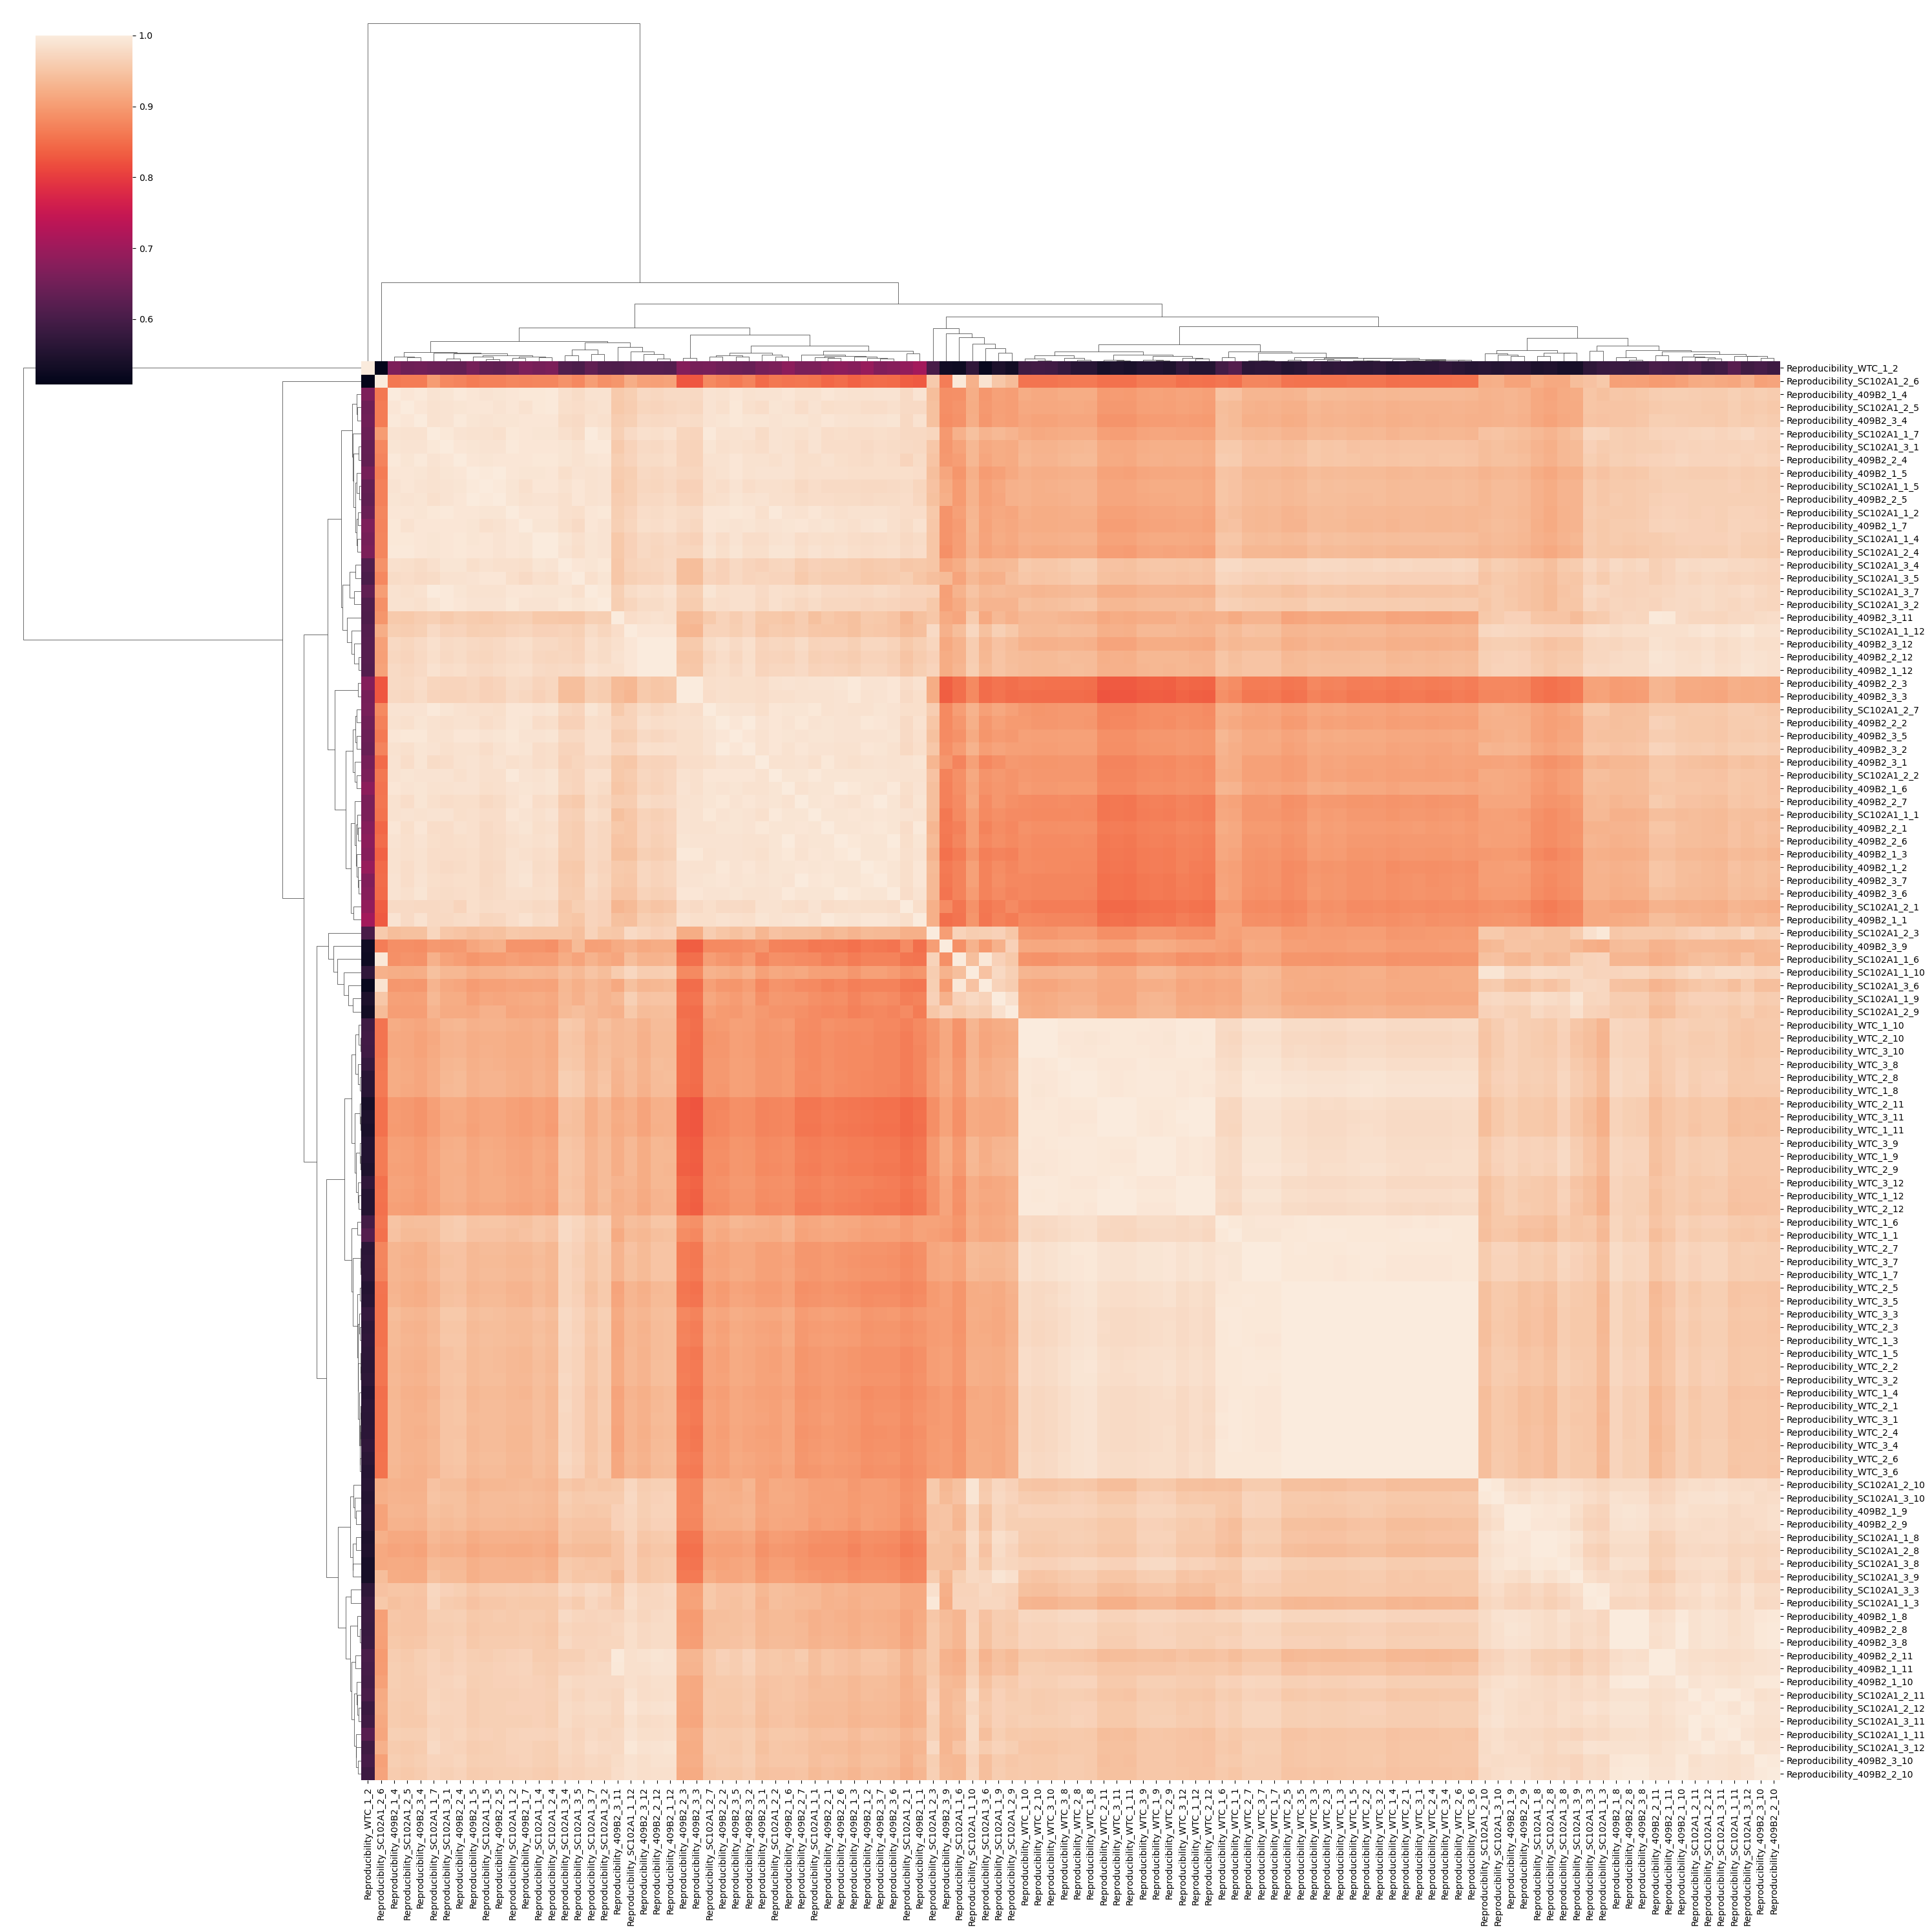

In [17]:
sns.clustermap(df_all_CPM.loc[var_genes].corr(),figsize=(30,30))

In [18]:
meta = pd.DataFrame(index=df_all_CPM.columns)
import re
meta['age'] = [re.sub("Stability_","",re.sub("_sample.*","",x)) for x in meta.index]
meta['sample'] = [re.sub(".*_sample_","",x) for x in meta.index]


ValueError: The number of observations cannot be determined on an empty distance matrix.

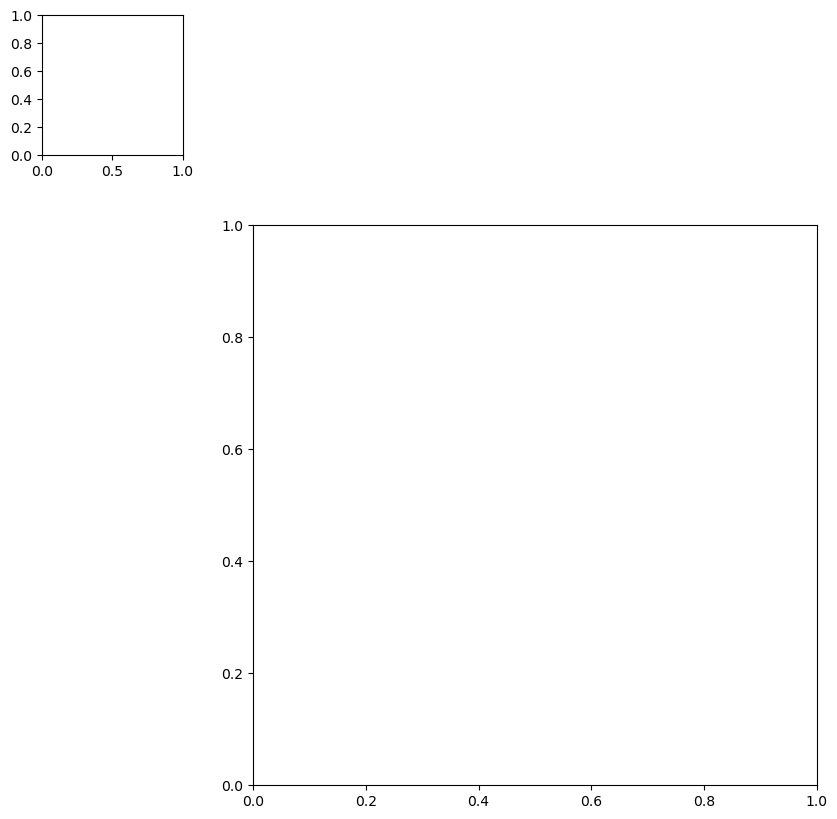

In [19]:
for age in list(set(meta['age'])):
    age_samples = meta.loc[meta['age']==age].index
    sns.clustermap(df_all_CPM.loc[var_genes,age_samples].corr(),figsize=(10,10))
    plt.show()
    plt.close()

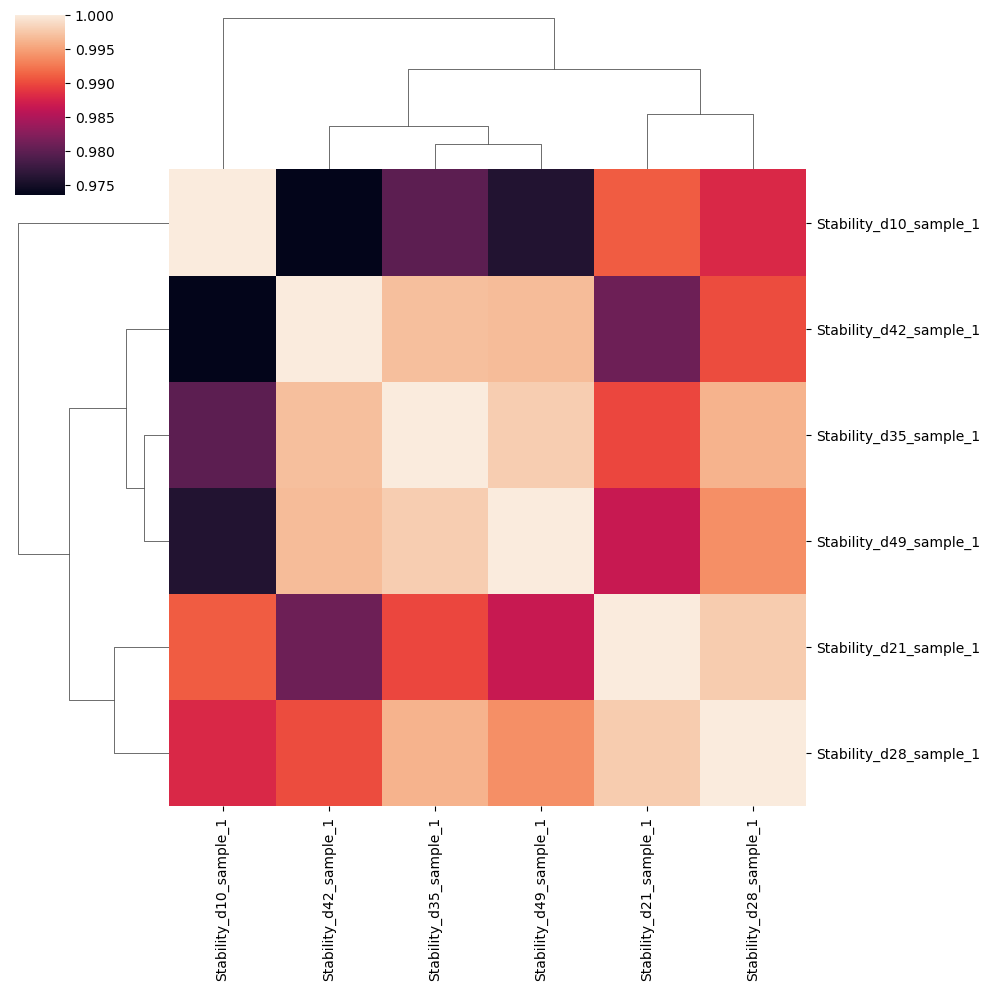

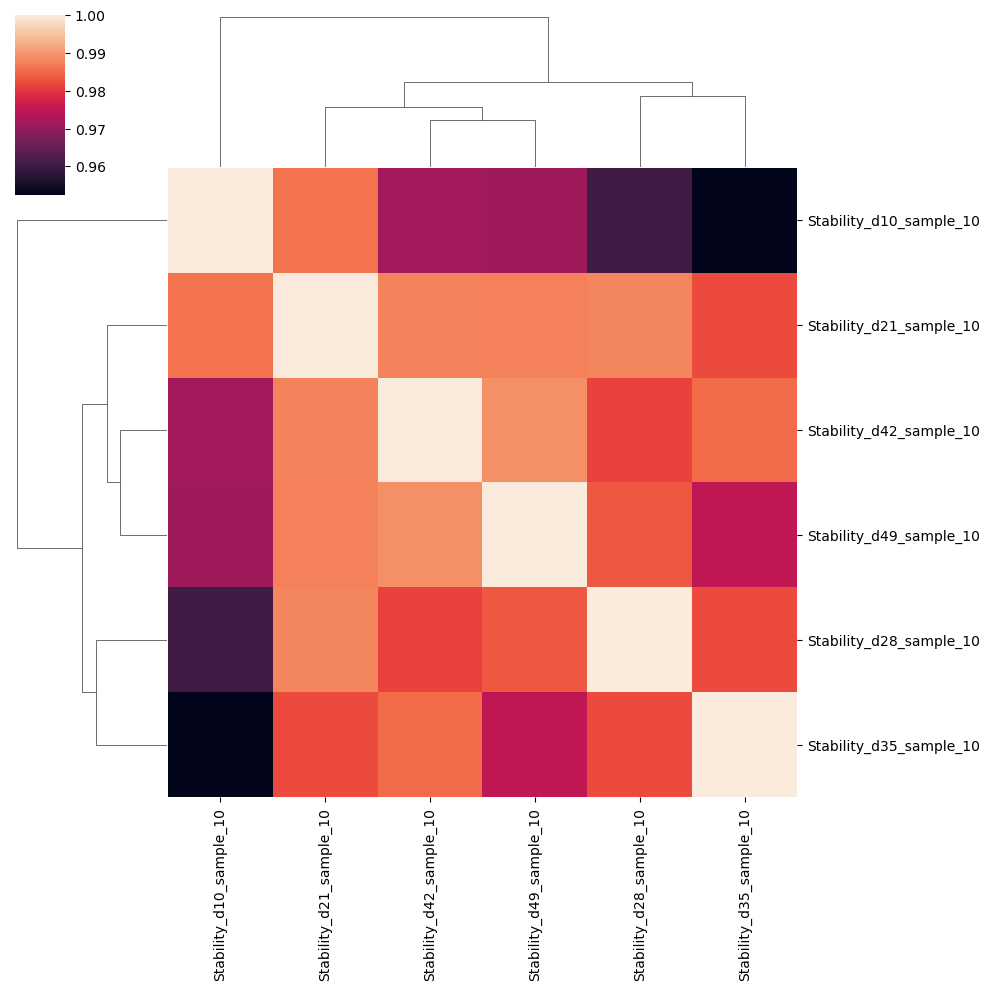

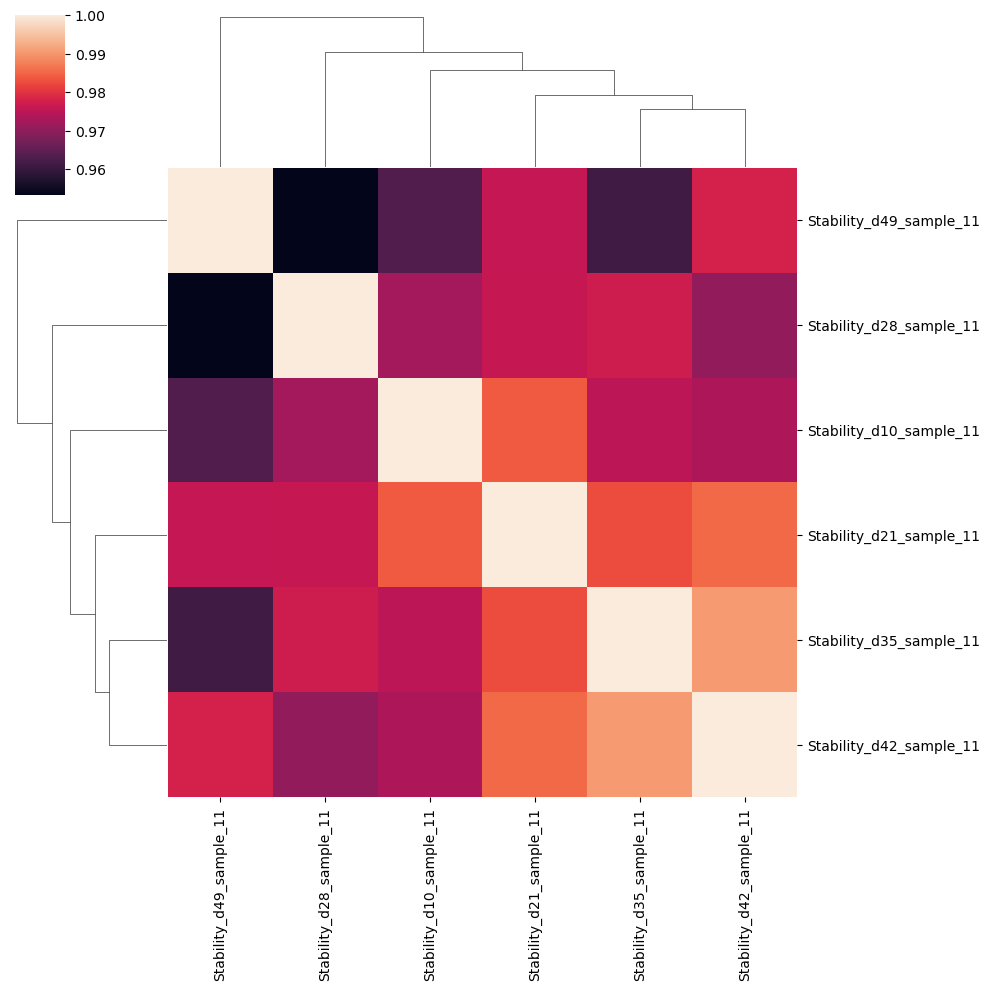

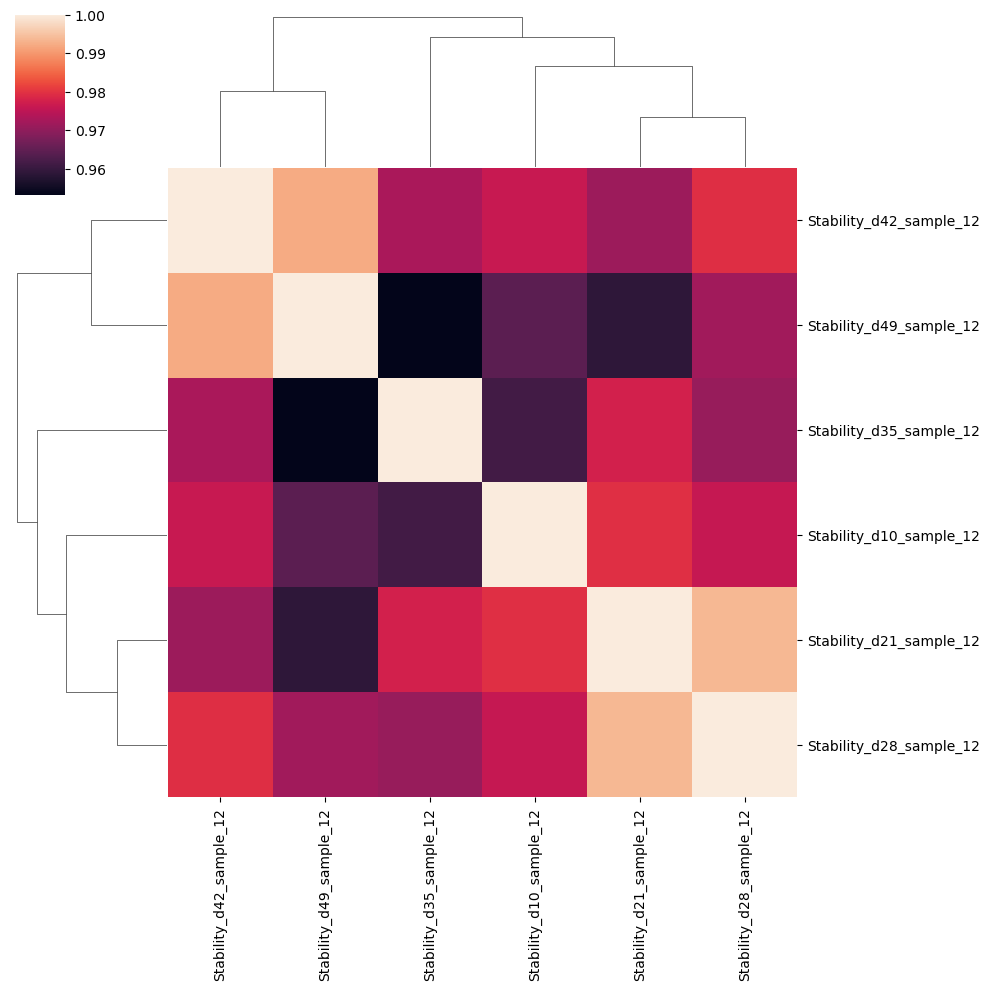

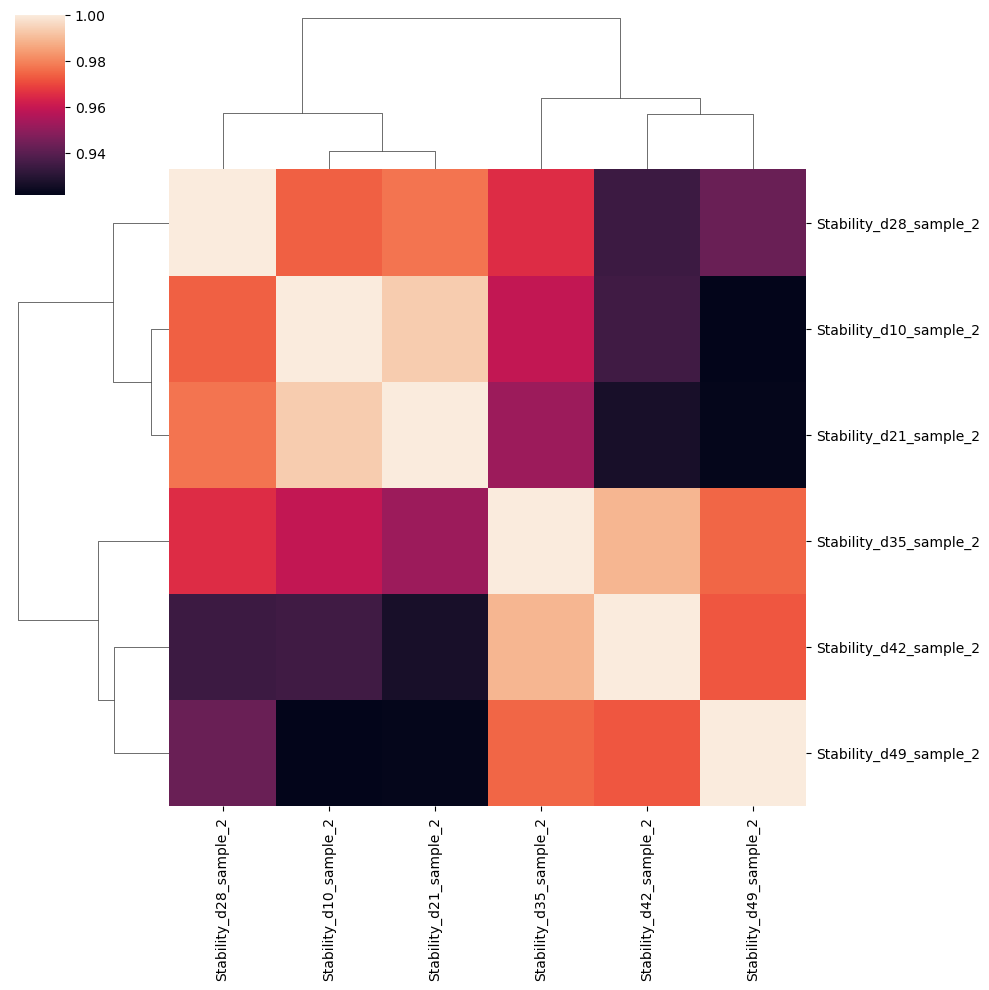

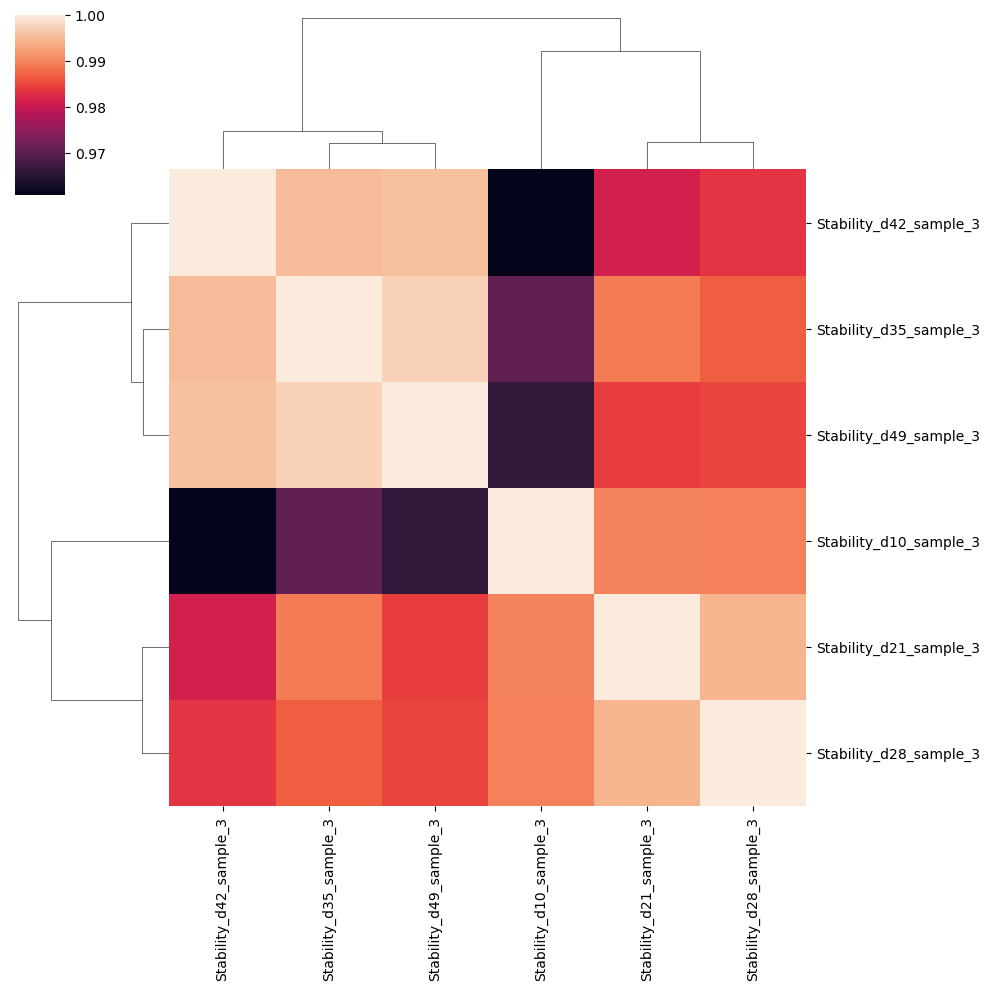

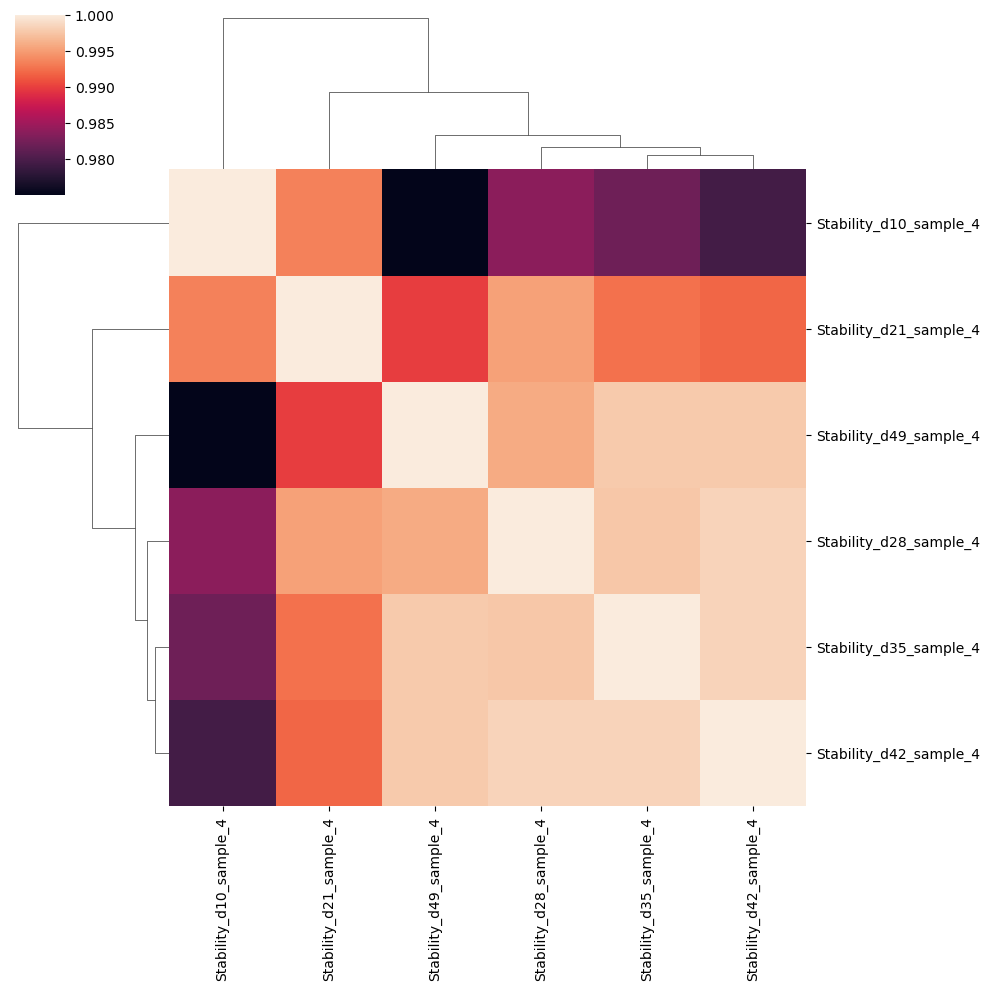

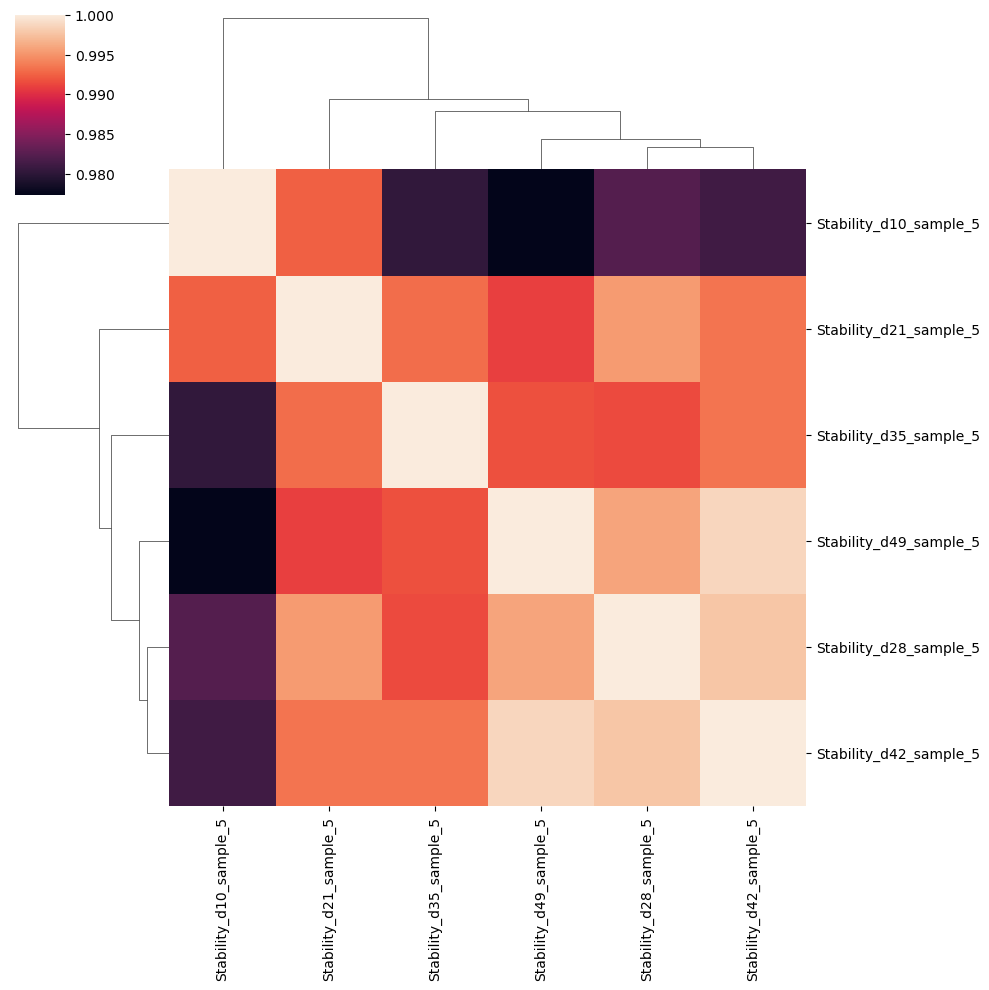

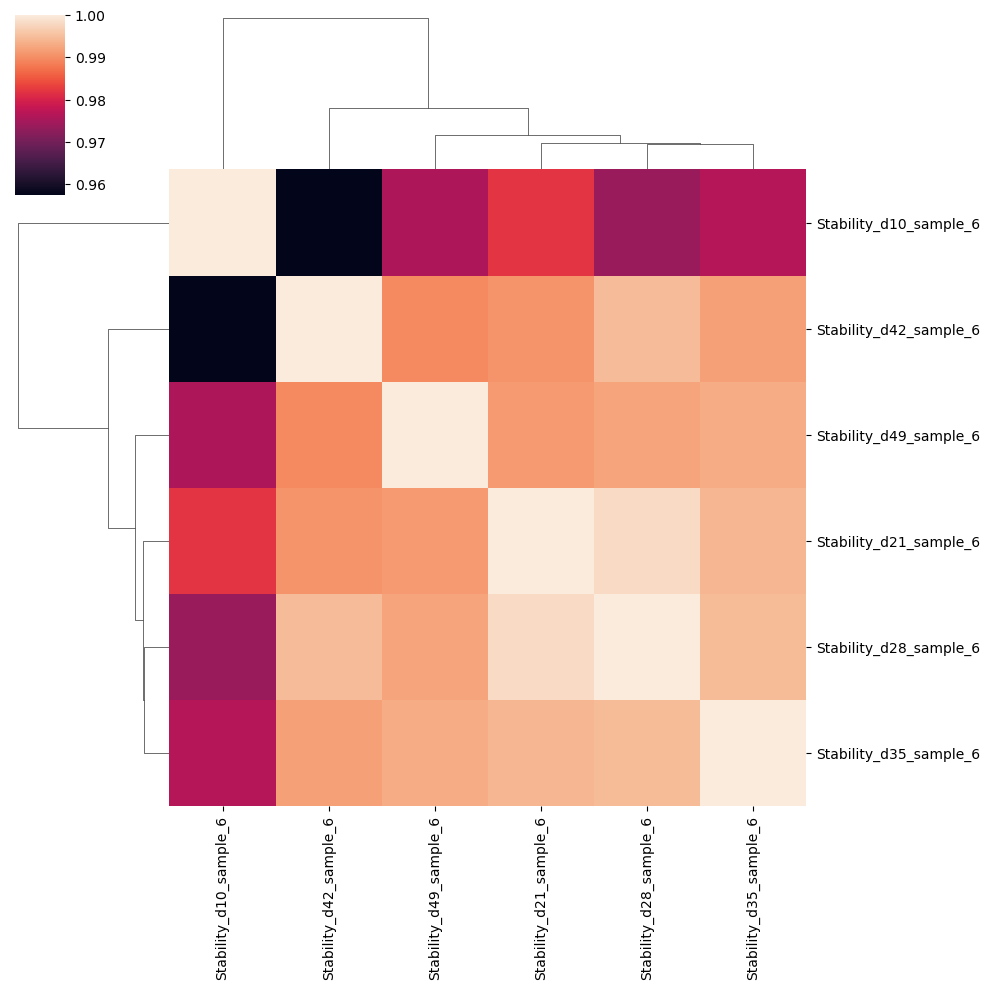

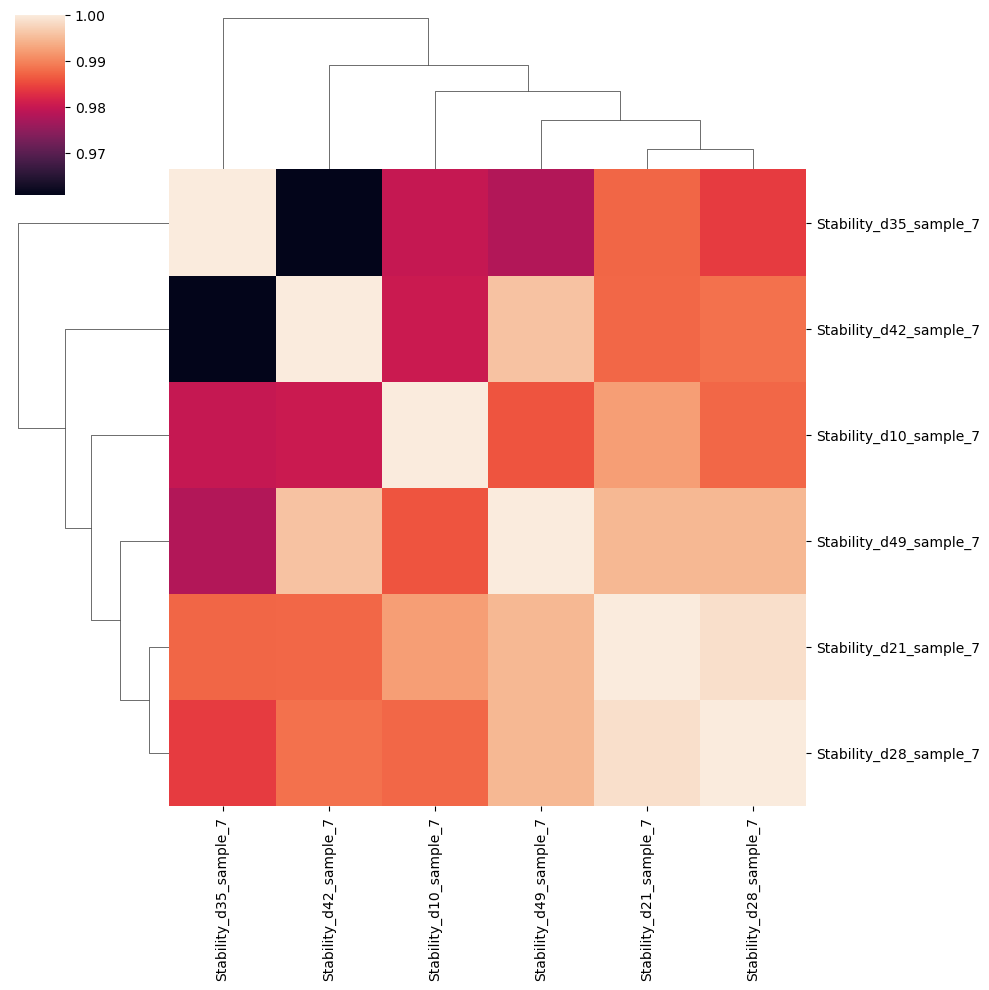

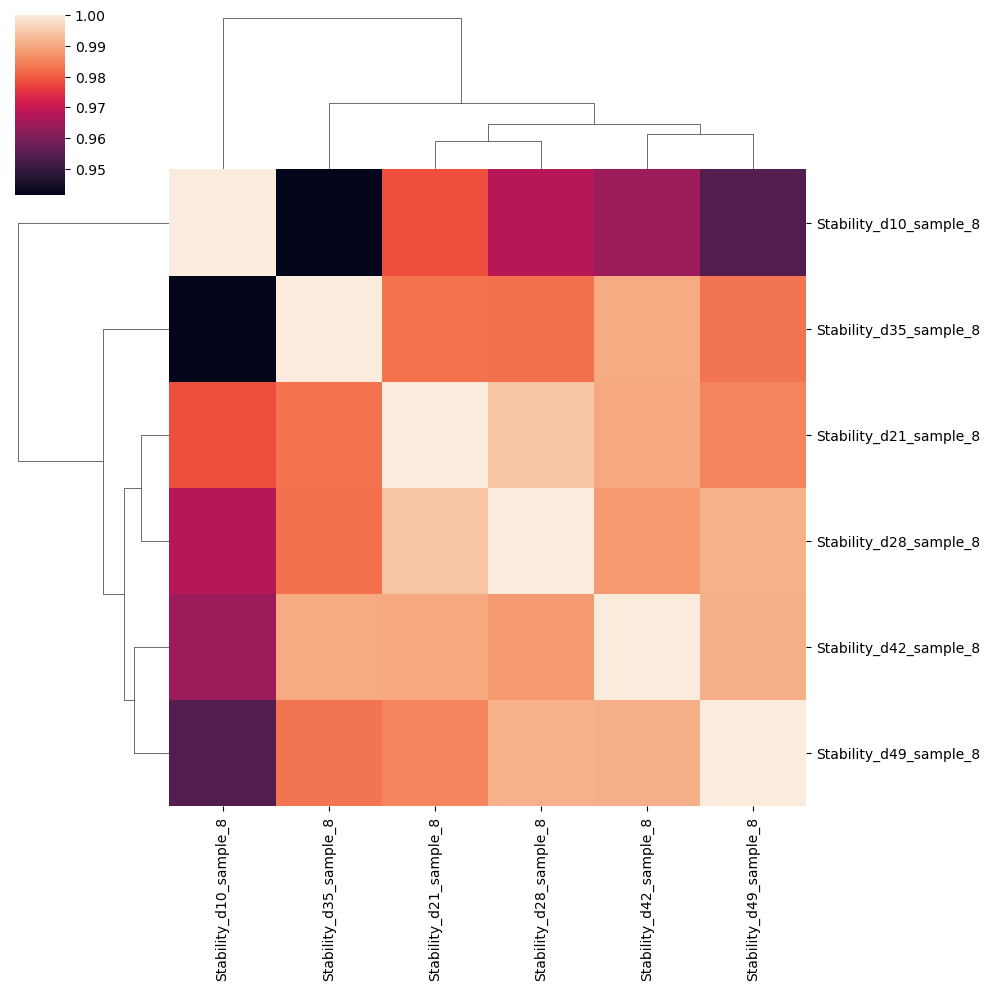

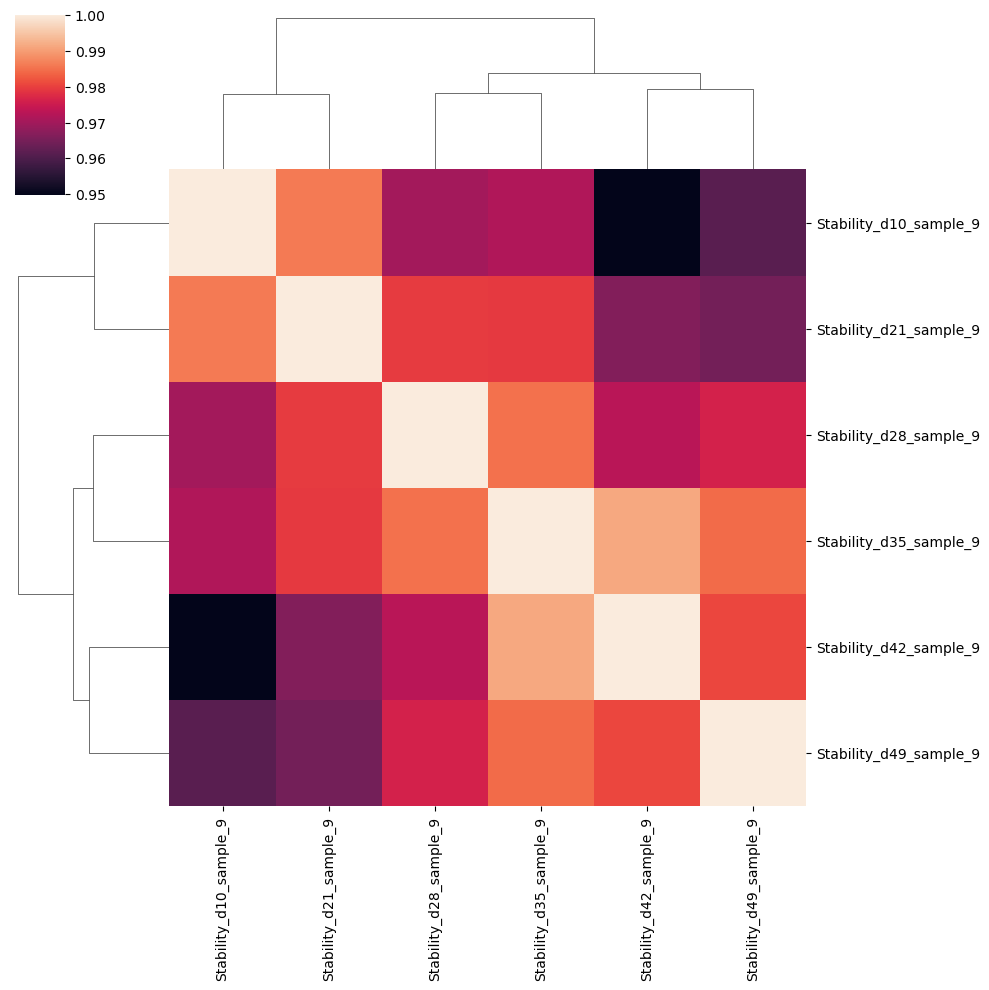

In [71]:
ordered_samples = []
meta = meta.sort_values(by=['sample','age'])

for sample in sorted(list(set(meta['sample']))):
    sample_samples = list(meta.loc[meta['sample']==sample].index)
    sns.clustermap(df_all_CPM.loc[var_genes,sample_samples].corr(),figsize=(10,10))
    plt.show()
    plt.close()

    ordered_samples = ordered_samples + sample_samples

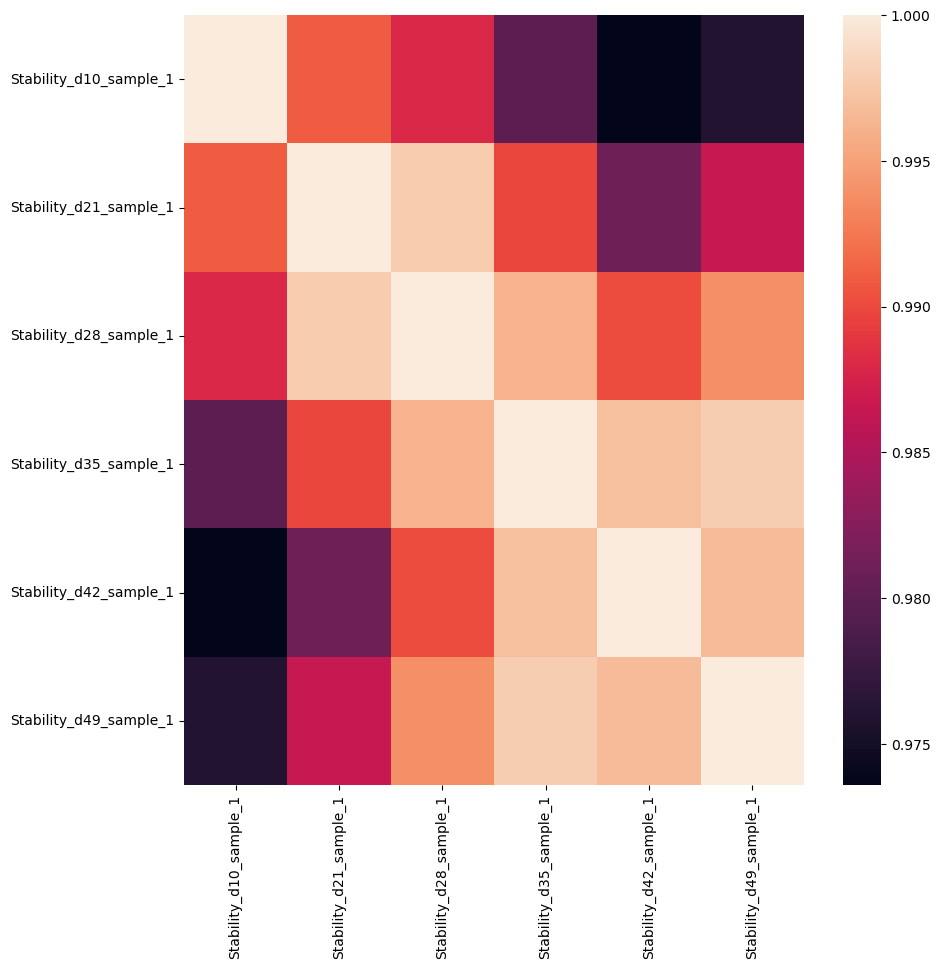

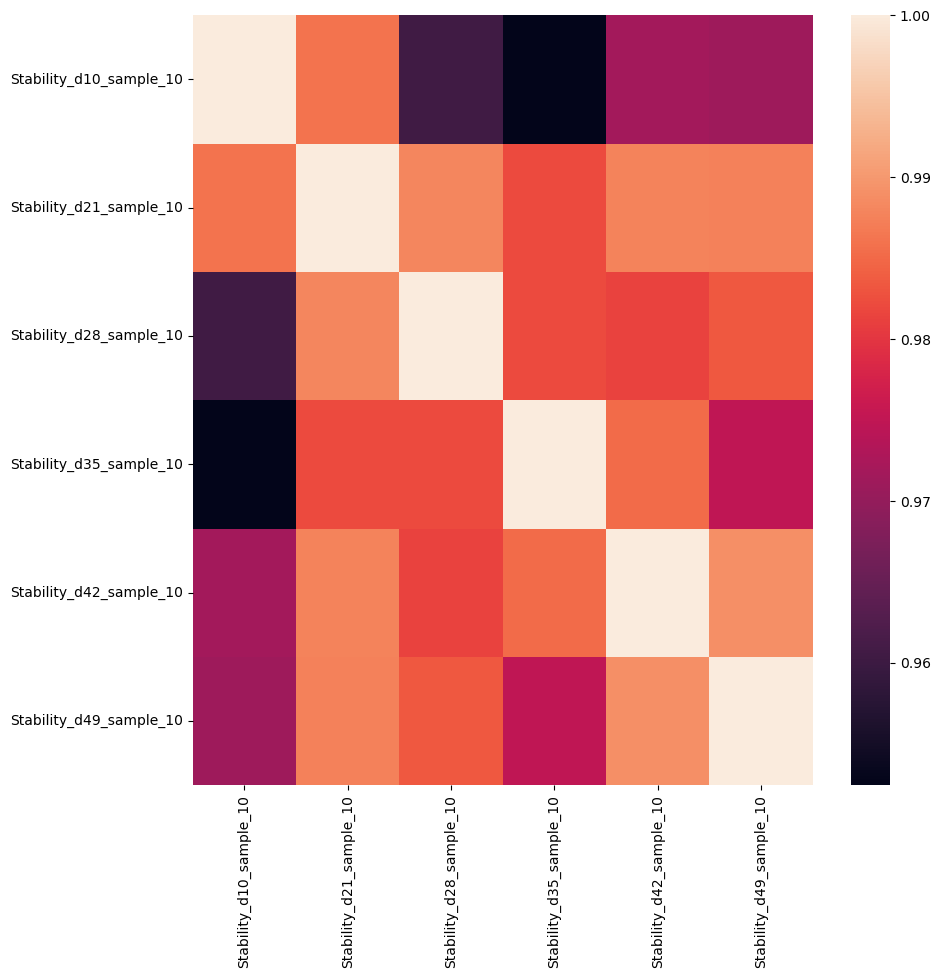

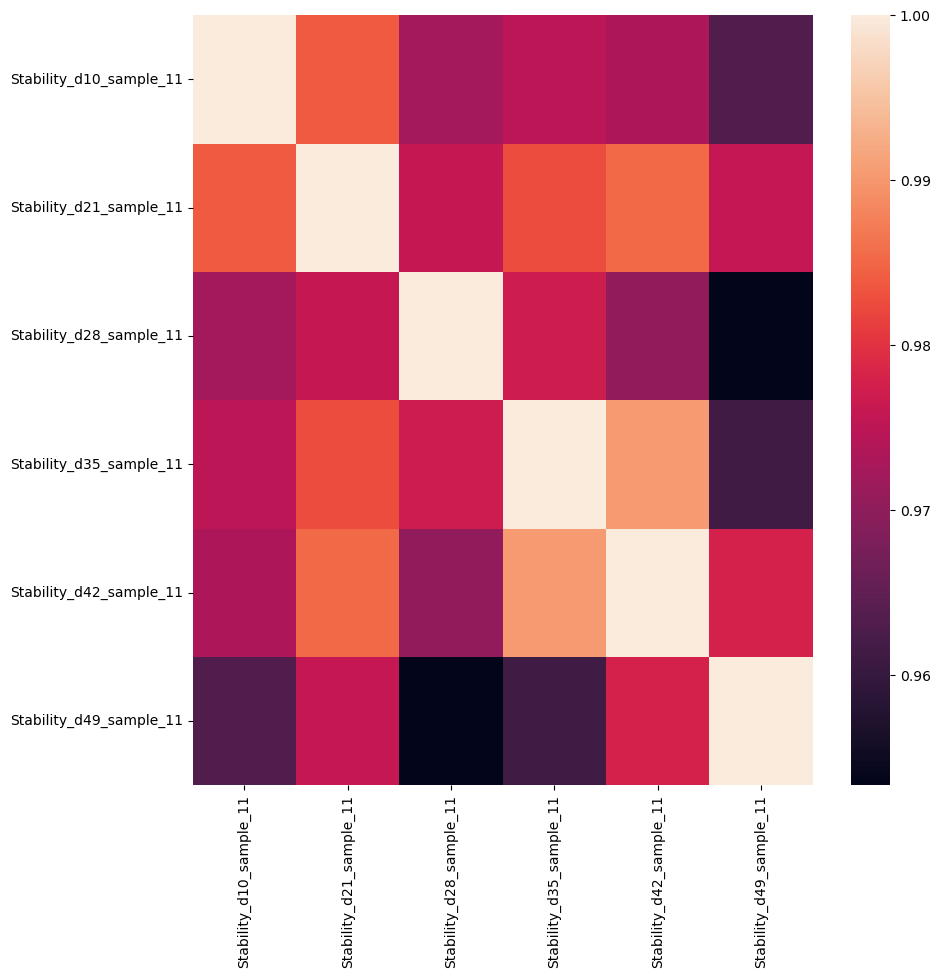

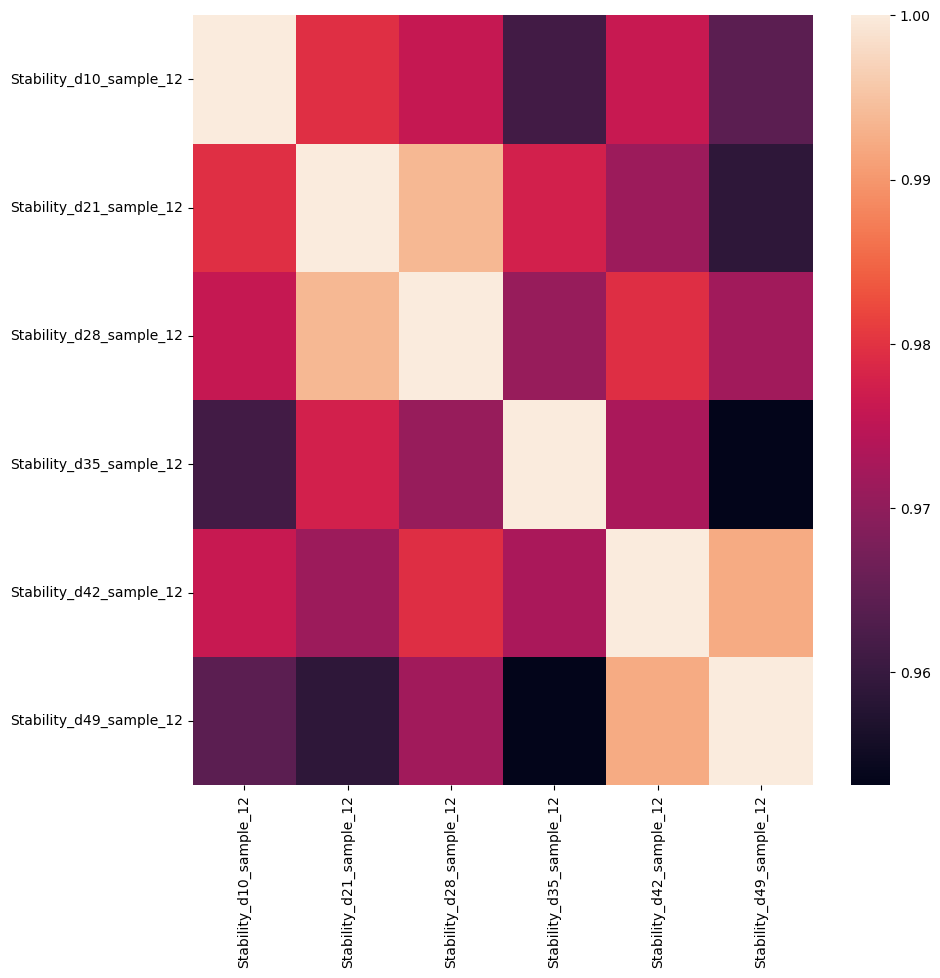

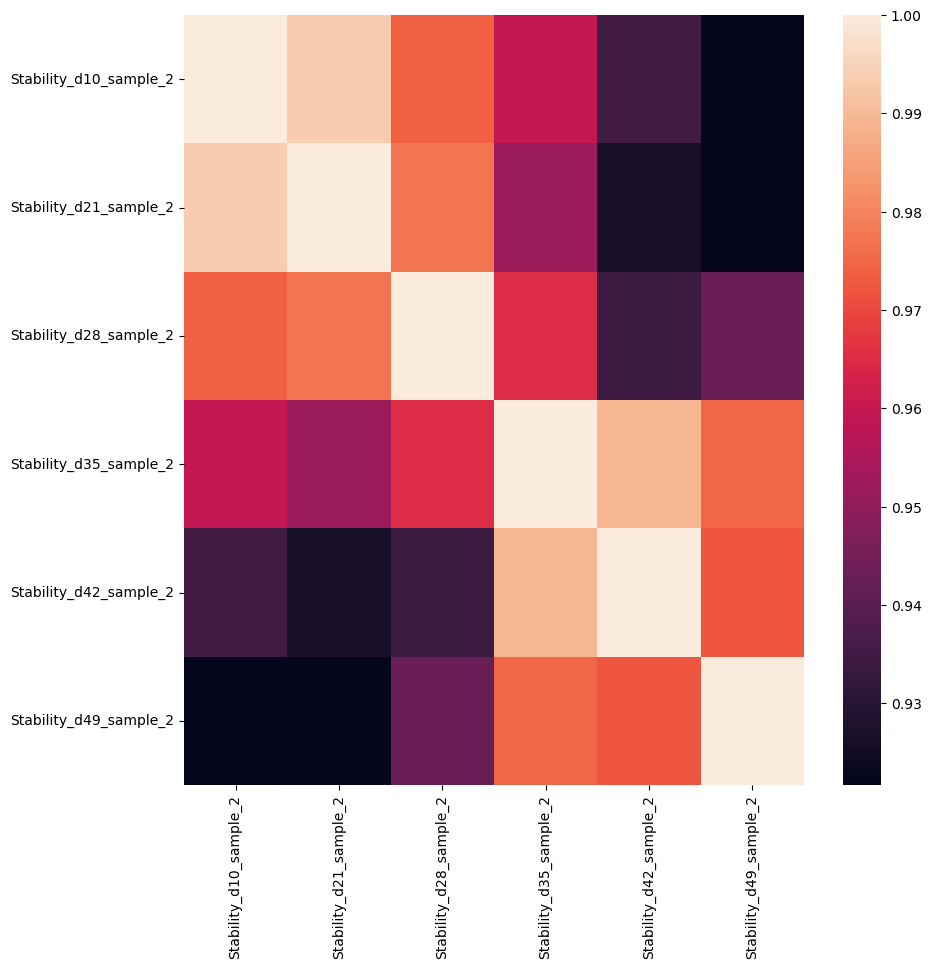

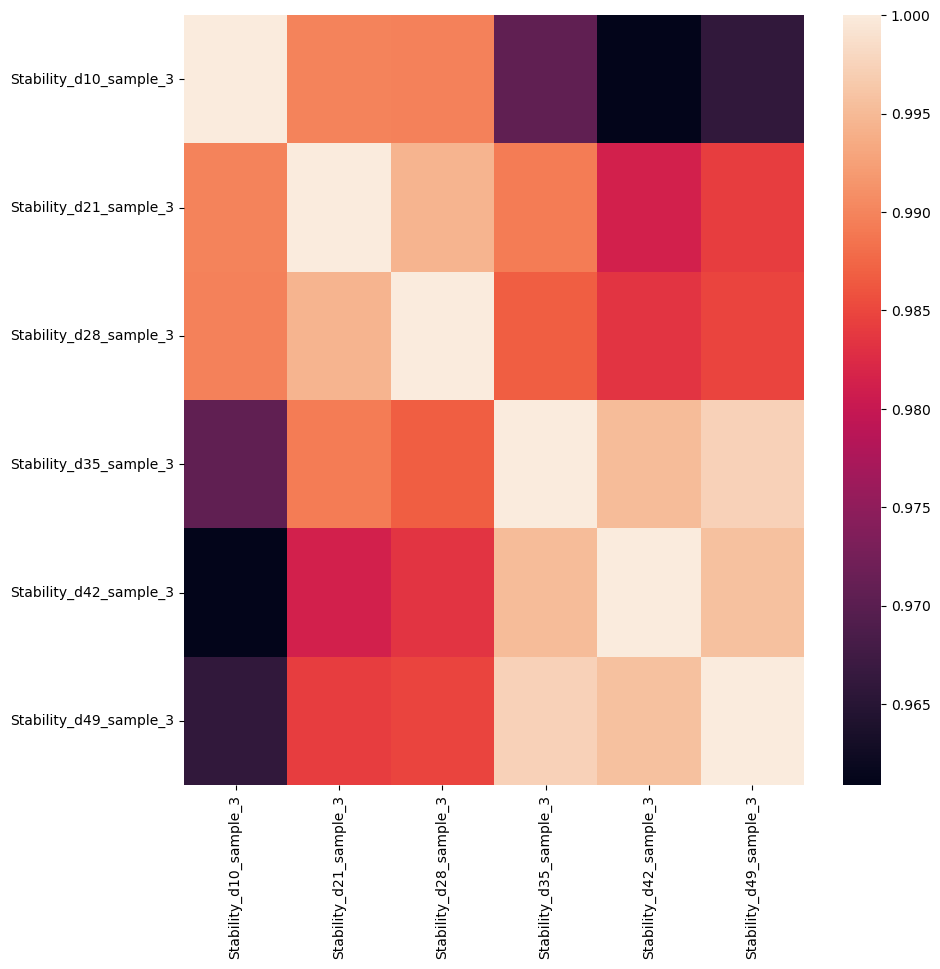

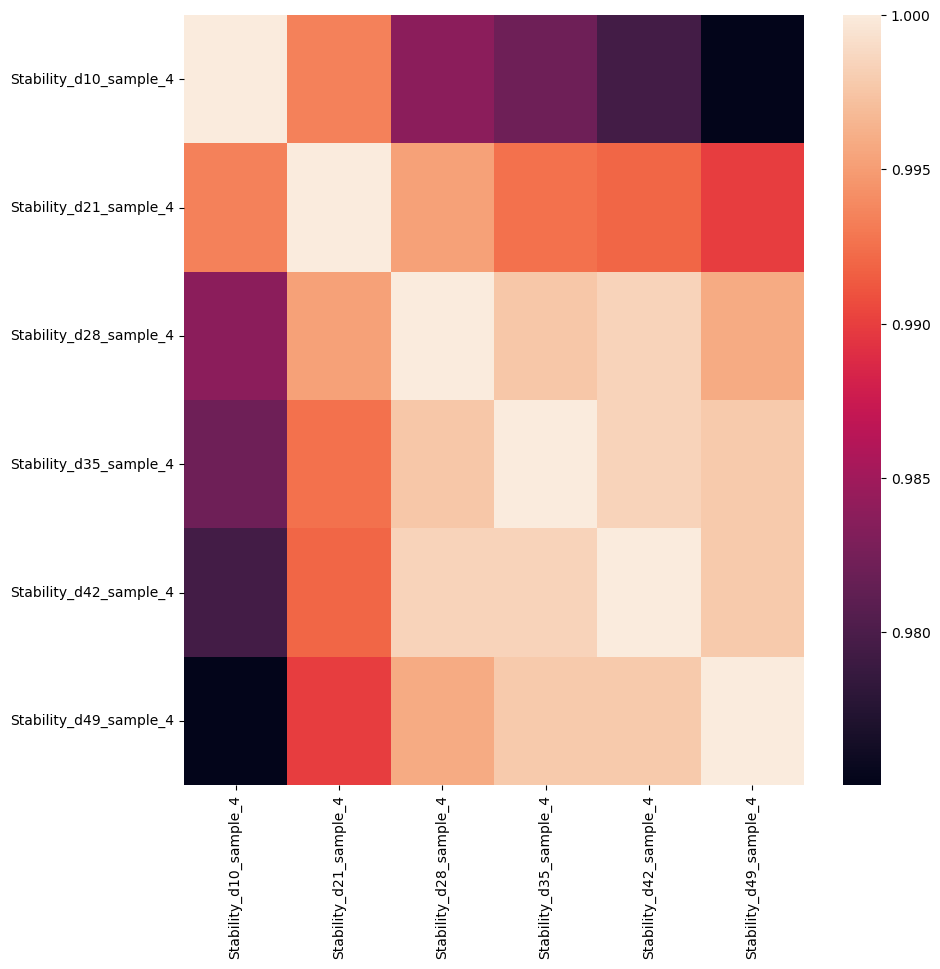

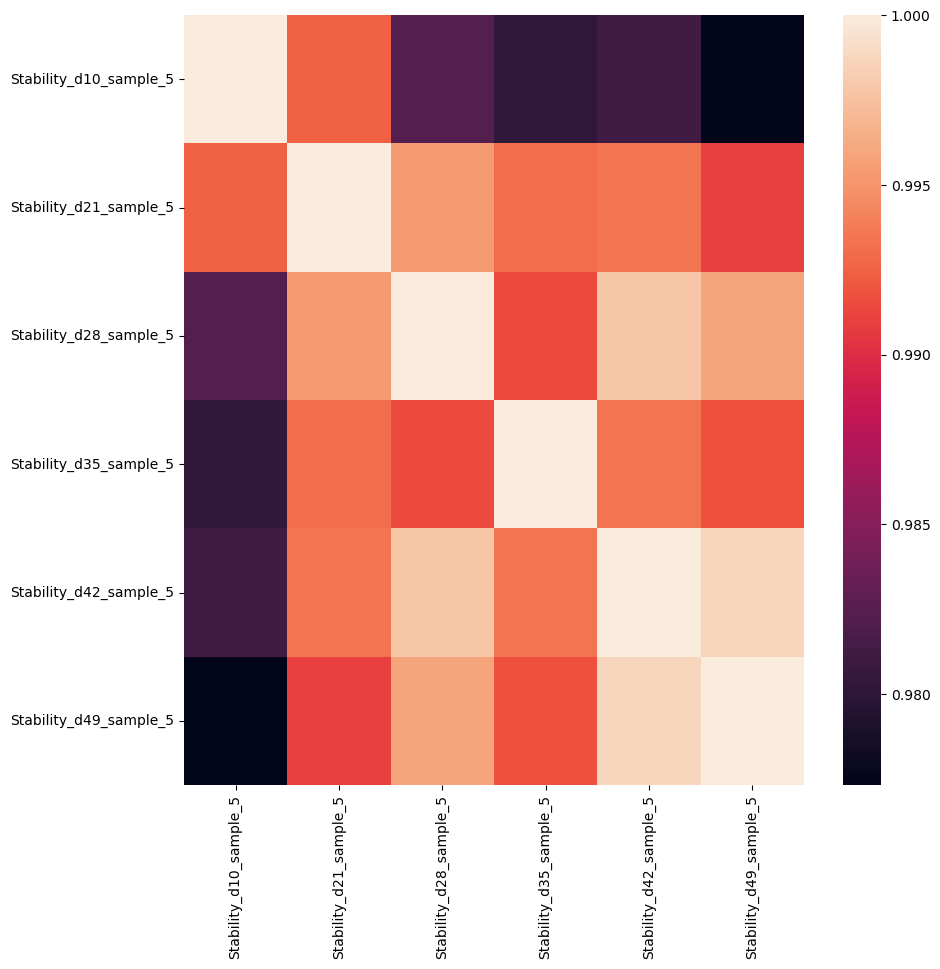

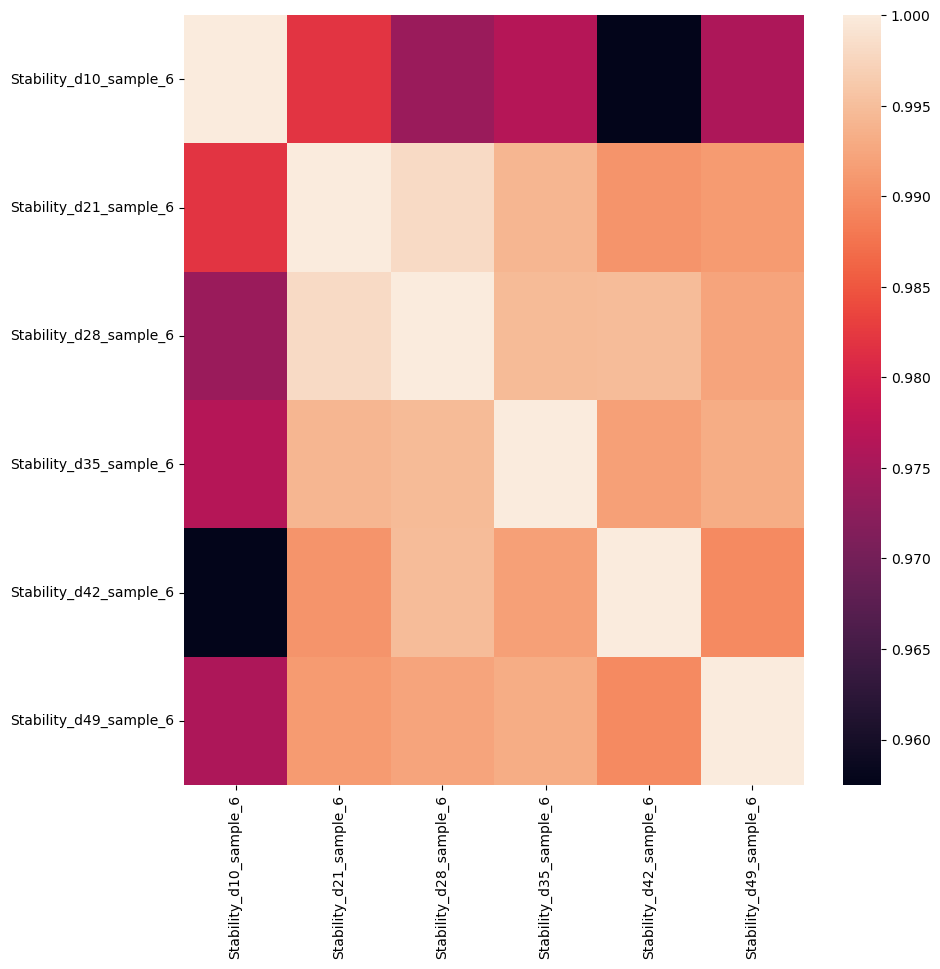

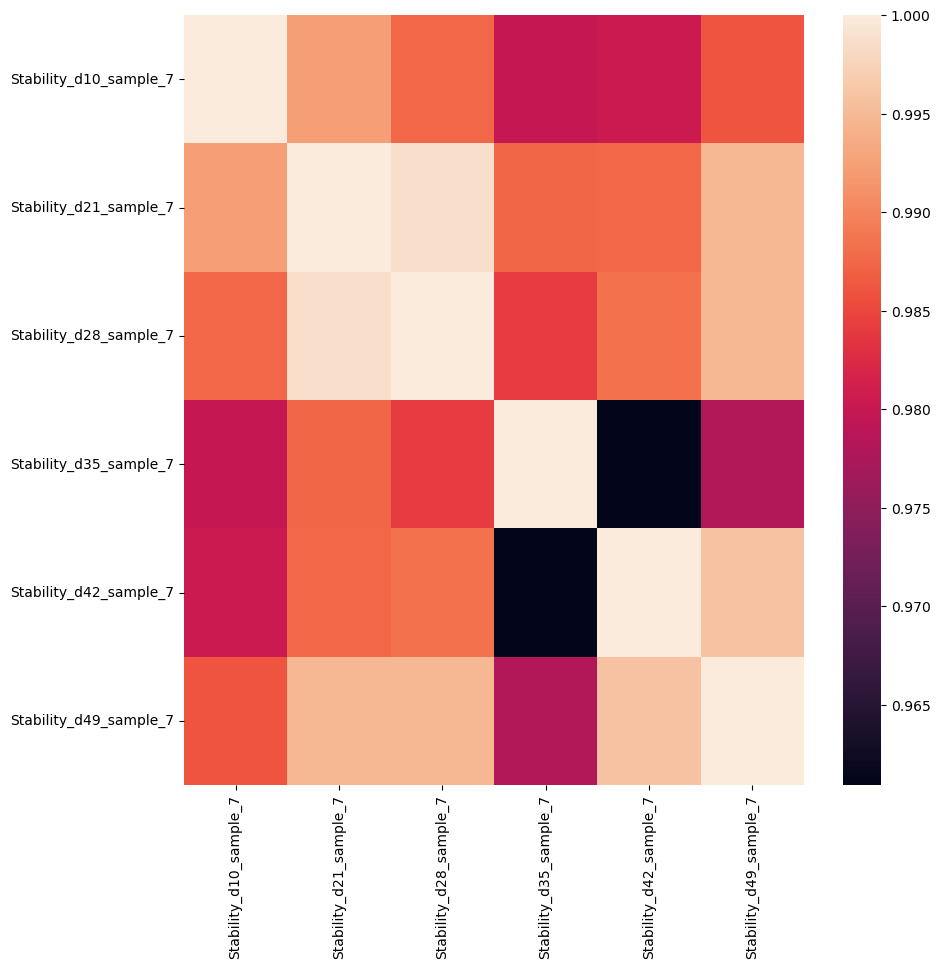

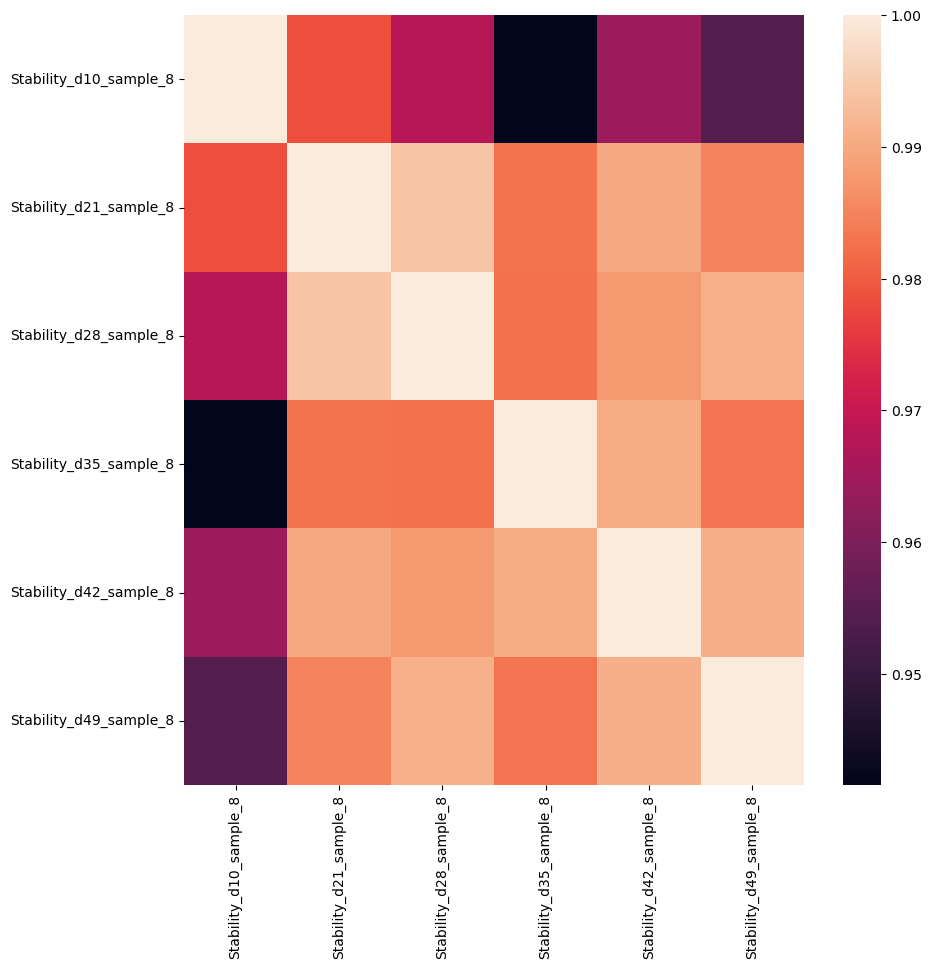

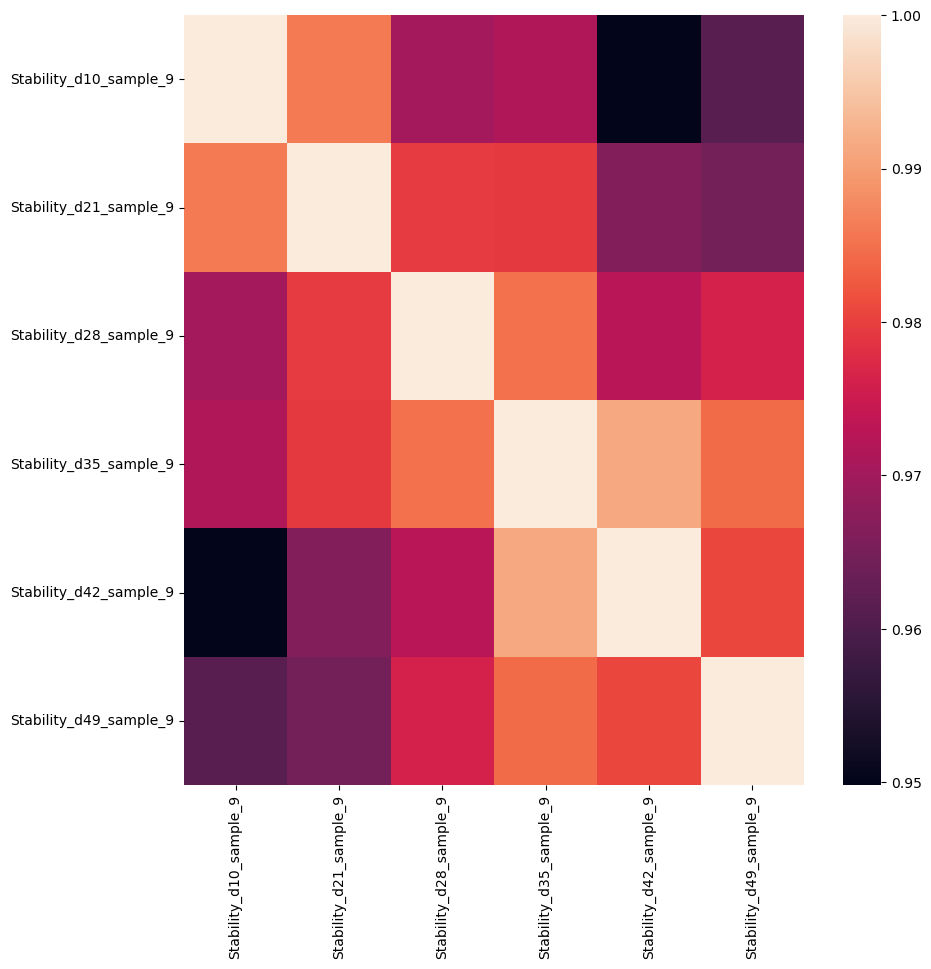

In [108]:
ordered_samples = []
meta = meta.sort_values(by=['sample','age'])
a_min = []
for sample in sorted(list(set(meta['sample']))):
    sample_samples = list(meta.loc[meta['sample']==sample].index)
    plt.figure(figsize=(10,10))
    sns.heatmap(df_all_CPM.loc[var_genes,sample_samples].corr(),vmin=0.92,vmax=1)
    plt.savefig("stability_plots/sample_"+sample+"_timepoints_corr_variablegenes.png",dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()

    ordered_samples = ordered_samples + sample_samples

    a_min.append(df_all_CPM.loc[var_genes,sample_samples].corr().min().min())

0.9735775127377414
0.9524257824562231
0.9533085064017714
0.9531277221718979
0.9216863834122349
0.9608759256945191
0.9750512680694298
0.9773160758721067
0.9574841888976291
0.9609194813482748
0.9415618955302942
0.9498040766735429


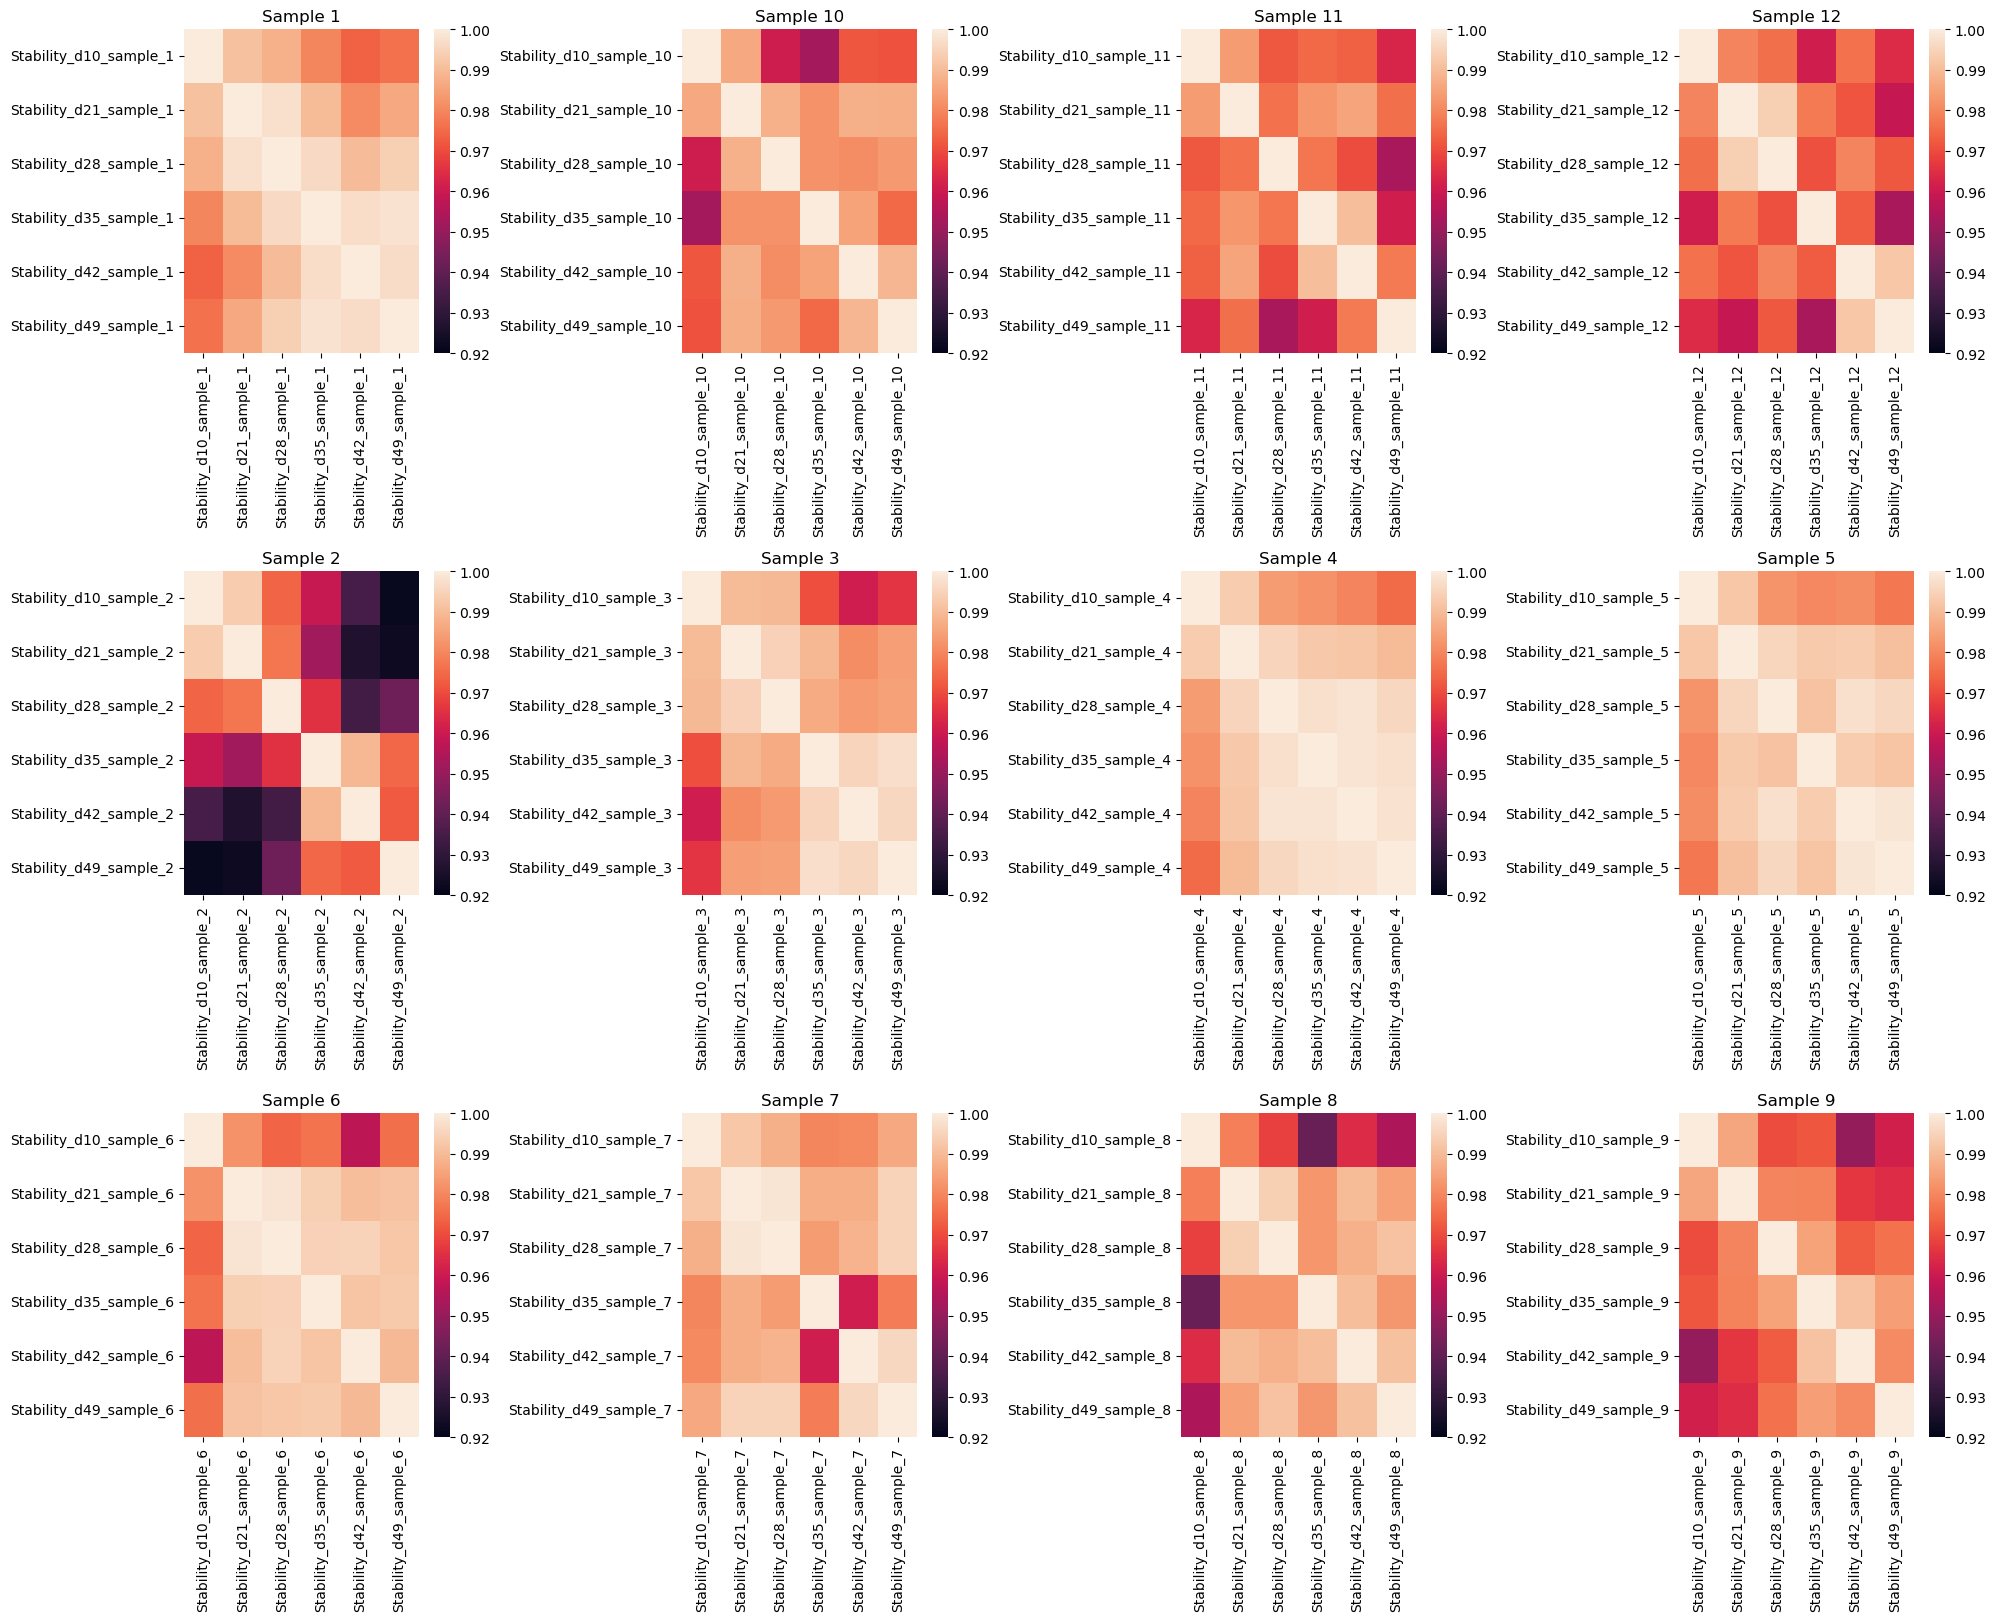

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'meta' and 'df_all_CPM' are your DataFrame objects and 'var_genes' is your list of variable genes

ordered_samples = []
meta = meta.sort_values(by=['sample', 'age'])

# Get unique samples and determine grid size
unique_samples = sorted(list(set(meta['sample'])))
num_samples = len(unique_samples)
grid_size = int(np.ceil(np.sqrt(num_samples)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
axes = axes.flatten()

for i, sample in enumerate(unique_samples):
    sample_samples = list(meta.loc[meta['sample'] == sample].index)
    
    # Plot heatmap on the corresponding subplot
    sns.heatmap(df_all_CPM.loc[var_genes, sample_samples].corr(), ax=axes[i],vmin=0.92,vmax=1)
    
    # Set title for each subplot
    axes[i].set_title(f'Sample {sample}')
    
    # Save each individual heatmap if needed
    plt.figure(figsize=(10, 10))
    sns.heatmap(df_all_CPM.loc[var_genes, sample_samples].corr())
    plt.savefig(f"stability_plots/sample_{sample}_timepoints_corr_variablegenes.png", dpi=350, bbox_inches='tight', pad_inches=0)
    plt.close()

    ordered_samples += sample_samples

    # Print the minimum correlation value for each sample
    print(df_all_CPM.loc[var_genes, sample_samples].corr().min().min())

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("stability_plots/grid_heatmap.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
time_deseq2 = pd.read_csv("stability_plots/deseq2_time.tsv",sep="\t")
time_deseq2['signed_pval'] = np.sign(time_deseq2['log2FoldChange'])*-np.log10(time_deseq2['pvalue'])

In [113]:
time_deseq2 = pd.read_csv("stability_plots/deseq2_time.tsv",sep="\t")

In [120]:
time_deseq2['signed_pval'] = np.sign(time_deseq2['log2FoldChange'])*-np.log10(time_deseq2['pvalue'])

In [134]:
df_all_CPM.loc['SCG2'].sort_values(ascending=False).head(n=20)

Stability_d49_sample_6     1252.338619
Stability_d42_sample_6     1230.033006
Stability_d49_sample_5     1172.177492
Stability_d42_sample_4     1109.856471
Stability_d49_sample_4     1055.891079
Stability_d35_sample_6      945.082403
Stability_d42_sample_5      894.350640
Stability_d49_sample_3      813.560820
Stability_d35_sample_4      698.793117
Stability_d35_sample_5      625.430521
Stability_d49_sample_1      593.570923
Stability_d42_sample_1      538.337955
Stability_d35_sample_3      504.603627
Stability_d35_sample_1      465.030196
Stability_d28_sample_5      432.080696
Stability_d28_sample_4      421.658162
Stability_d49_sample_10     417.637339
Stability_d49_sample_7      399.011786
Stability_d28_sample_6      380.549496
Stability_d49_sample_11     380.278943
Name: SCG2, dtype: float64

In [122]:
-np.log10(6.341472e-01)

0.19780992078140155

In [125]:
neg_genes = list(time_deseq2.sort_values(by='signed_pval').index)
pos_genes = list(time_deseq2.sort_values(by='signed_pval',ascending=False).index)

In [128]:
with open('stability_plots/neg_genes.txt', 'w') as f:
    for line in neg_genes:
        f.write(f"{line}\n")

with open('stability_plots/pos_genes.txt', 'w') as f:
    for line in pos_genes:
        f.write(f"{line}\n")


In [126]:
neg_genes

['LIN28A',
 'NR6A1',
 'LIN28B',
 'EBF2',
 'ARID3B',
 'WFIKKN1',
 'SDK1',
 'ONECUT2',
 'RAI14',
 'ARID3A',
 'NHLH2',
 'SIX1',
 'CASP3',
 'GRK5',
 'PPP2R1B',
 'UBE2G1',
 'MDGA1',
 'GRM2',
 'ONECUT3',
 'GREB1L',
 'SCML2',
 'PGD',
 'CBX5',
 'HAPLN1',
 'IGF2BP3',
 'GCNT4',
 'IGDCC3',
 'ZNF281',
 'PXDN',
 'THSD7B',
 'PRMT1',
 'EYA1',
 'SIM1',
 'PLEKHJ1',
 'PEAK1',
 'EBF3',
 'THOC5',
 'ITGB1',
 'SKIDA1',
 'AKIRIN2',
 'EPS8L1',
 'TMEM169',
 'SS18',
 'ARGLU1',
 'LYPLA1',
 'NDUFS6',
 'MKNK1',
 'HIC2',
 'AKIRIN1',
 'GREB1',
 'PFAS',
 'SEMA6D',
 'PIK3C2B',
 'PUDP',
 'ATXN7L2',
 'HOXA1',
 'DNAJC22',
 'SHC1',
 'LYPLA2',
 'SVIP',
 'XRN2',
 'KLHL4',
 'PPP1CA',
 'HOMEZ',
 'ZNF124',
 'YTHDF2',
 'ATP5MC2',
 'LDLRAD3',
 'ENPP1',
 'PFN1',
 'CRIM1',
 'KCTD10',
 'LZTS2',
 'ILF3',
 'ENSG00000250360',
 'INKA2',
 'GTF3C5',
 'NEFM',
 'PLEKHG2',
 'STK38',
 'MPDU1',
 'DANCR',
 'PPIA',
 'PELI1',
 'SALL4',
 'RGS10',
 'ADAM12',
 'H3-3A',
 'PPP1R17',
 'NR2C1',
 'MAML3',
 'SWSAP1',
 'PRKG1',
 'IGF1R',
 'ASCC2',
 'DDX5'

In [109]:
np.min(a_min)

0.9216863834122349

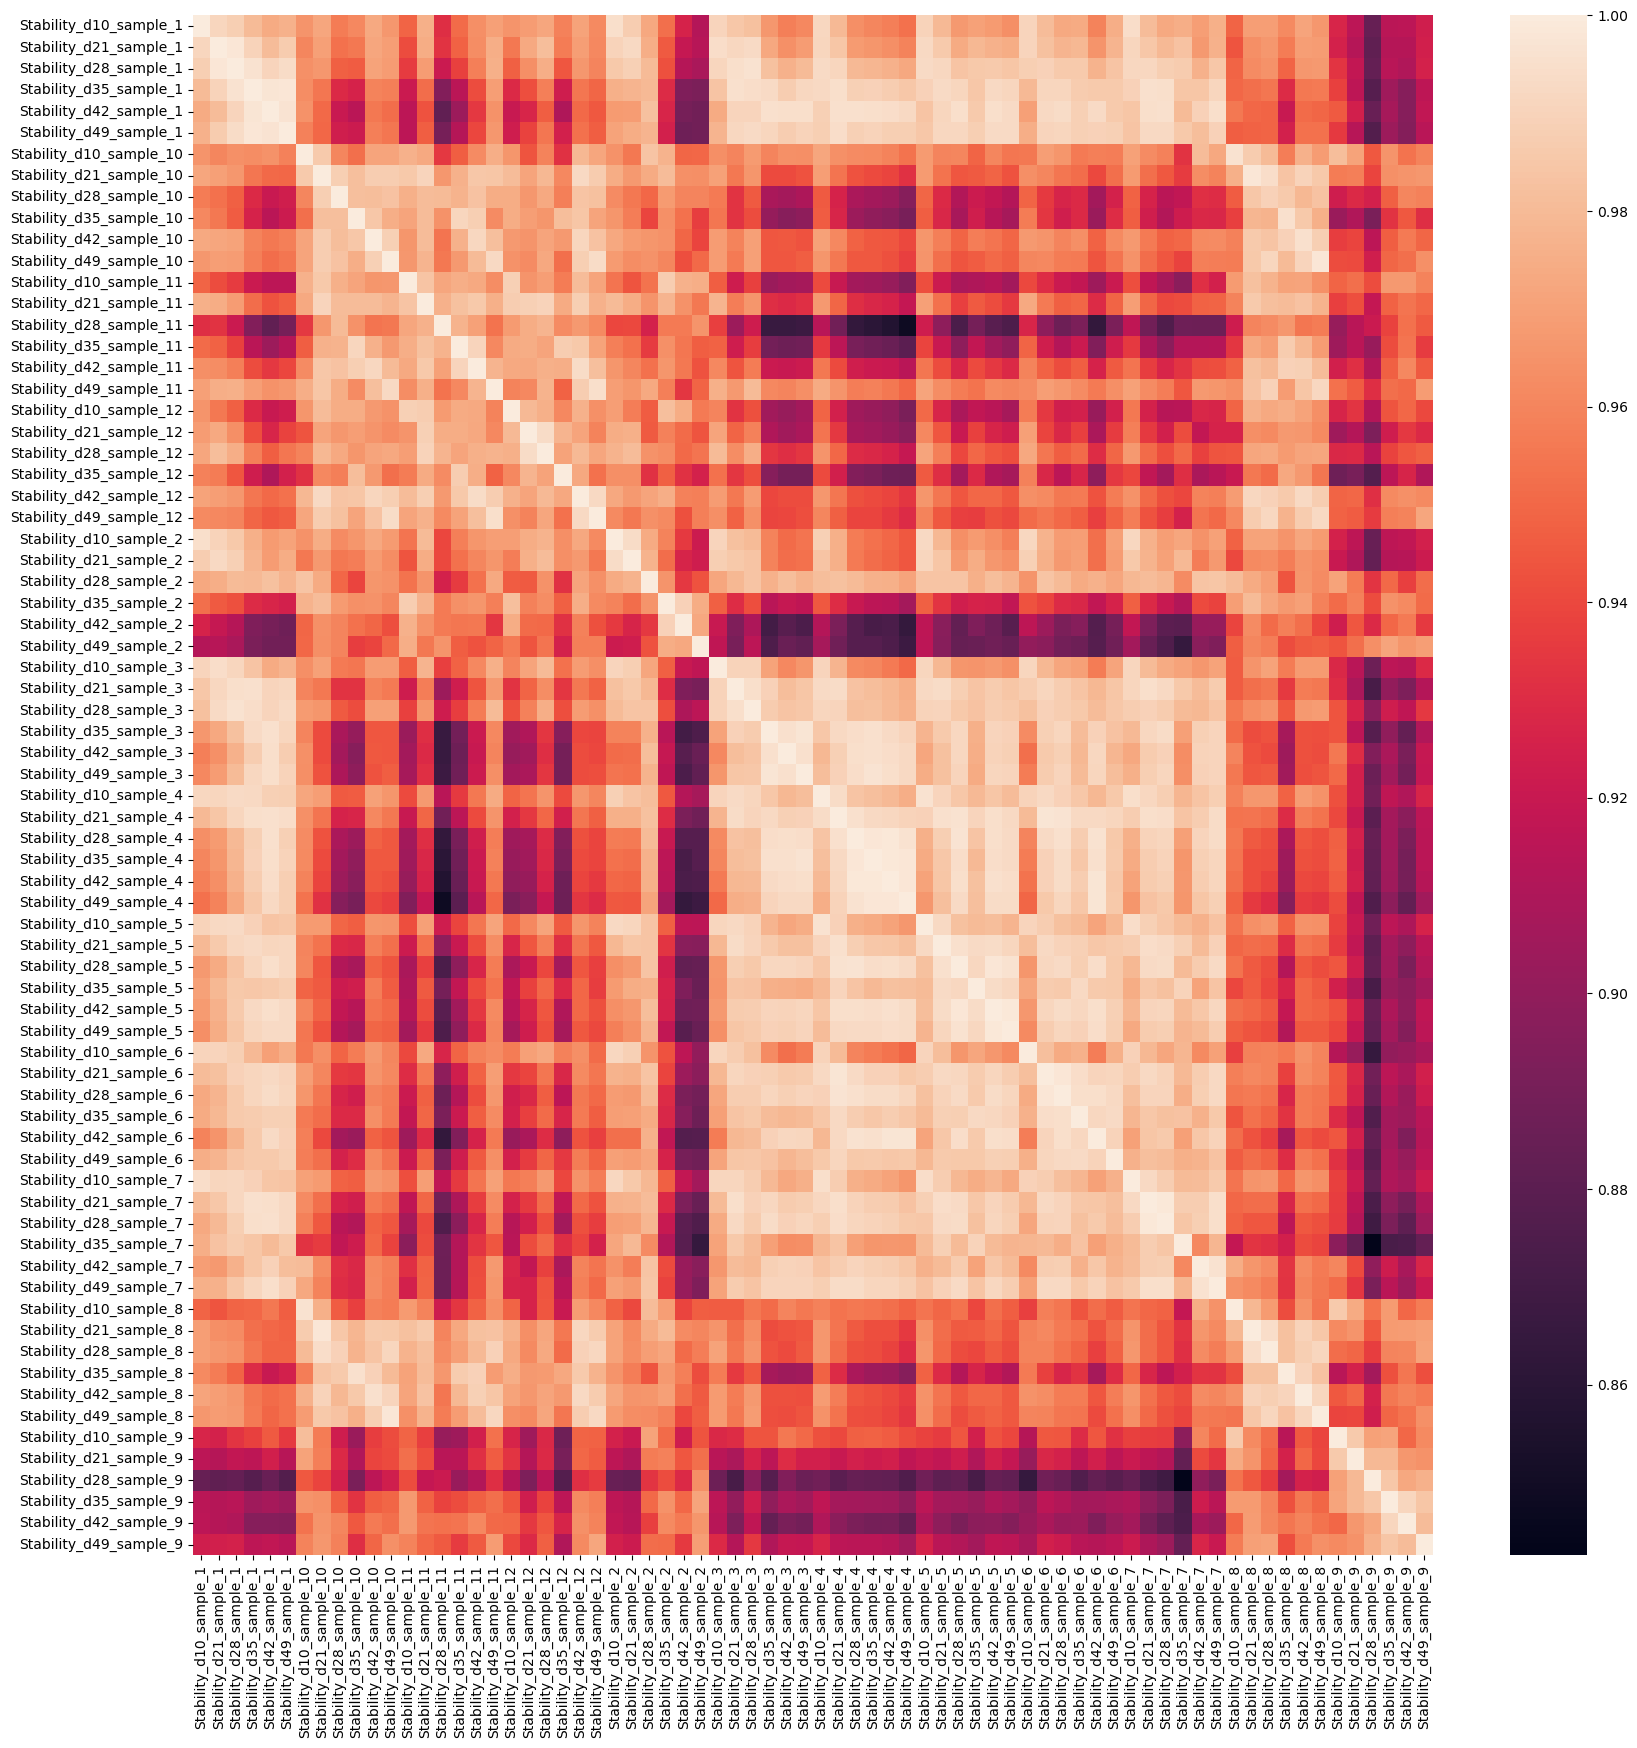

In [73]:
plt.figure(figsize=(20,20))
sns.heatmap(df_all_CPM.loc[var_genes,ordered_samples].corr())
plt.savefig("stability_plots/samples_correlation_1000var_CPM.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

['Stability_d10_sample_4',
 'Stability_d21_sample_4',
 'Stability_d28_sample_4',
 'Stability_d35_sample_4',
 'Stability_d42_sample_4',
 'Stability_d49_sample_4',
 'Stability_d10_sample_6',
 'Stability_d21_sample_6',
 'Stability_d28_sample_6',
 'Stability_d35_sample_6',
 'Stability_d42_sample_6',
 'Stability_d49_sample_6',
 'Stability_d10_sample_9',
 'Stability_d21_sample_9',
 'Stability_d28_sample_9',
 'Stability_d35_sample_9',
 'Stability_d42_sample_9',
 'Stability_d49_sample_9',
 'Stability_d10_sample_10',
 'Stability_d21_sample_10',
 'Stability_d28_sample_10',
 'Stability_d35_sample_10',
 'Stability_d42_sample_10',
 'Stability_d49_sample_10',
 'Stability_d10_sample_3',
 'Stability_d21_sample_3',
 'Stability_d28_sample_3',
 'Stability_d35_sample_3',
 'Stability_d42_sample_3',
 'Stability_d49_sample_3',
 'Stability_d10_sample_1',
 'Stability_d21_sample_1',
 'Stability_d28_sample_1',
 'Stability_d35_sample_1',
 'Stability_d42_sample_1',
 'Stability_d49_sample_1',
 'Stability_d10_sample

In [60]:
sample_samples

Index(['Stability_d10_sample_4', 'Stability_d21_sample_4',
       'Stability_d28_sample_4', 'Stability_d35_sample_4',
       'Stability_d42_sample_4', 'Stability_d49_sample_4'],
      dtype='object')

In [48]:
meta.index

Index(['Stability_d21_sample_9', 'Stability_d21_sample_4',
       'Stability_d21_sample_5', 'Stability_d21_sample_10',
       'Stability_d21_sample_7', 'Stability_d21_sample_6',
       'Stability_d21_sample_1', 'Stability_d21_sample_12',
       'Stability_d21_sample_3', 'Stability_d21_sample_2',
       'Stability_d21_sample_11', 'Stability_d21_sample_8',
       'Stability_d49_sample_2', 'Stability_d49_sample_4',
       'Stability_d49_sample_11', 'Stability_d49_sample_3',
       'Stability_d49_sample_12', 'Stability_d49_sample_9',
       'Stability_d49_sample_1', 'Stability_d49_sample_6',
       'Stability_d49_sample_8', 'Stability_d49_sample_5',
       'Stability_d49_sample_10', 'Stability_d49_sample_7',
       'Stability_d35_sample_6', 'Stability_d35_sample_11',
       'Stability_d35_sample_9', 'Stability_d35_sample_8',
       'Stability_d35_sample_2', 'Stability_d35_sample_1',
       'Stability_d35_sample_3', 'Stability_d35_sample_5',
       'Stability_d35_sample_10', 'Stability_d35_

In [ ]:
df_all_CPM

In [16]:
!ls Stability_d21/Stability_d21_sample_9/10.MAPPING/

Stability_d21_sample_9_STAR_Aligned.sortedByCoord.out.bam
Stability_d21_sample_9_STAR_Log.final.out
Stability_d21_sample_9_STAR_Log.out
Stability_d21_sample_9_STAR_Log.progress.out
Stability_d21_sample_9_STAR_ReadsPerGene.out.tab
Stability_d21_sample_9_STAR_SJ.out.tab
Stability_d21_sample_9_STAR_Signal.Unique.str1.out.bg
Stability_d21_sample_9_STAR_Signal.UniqueMultiple.str1.out.bg
Stability_d21_sample_9_STAR_Unmapped.out.mate1
Stability_d21_sample_9_STAR_Unmapped.out.mate2
Stability_d21_sample_9_STAR__STARtmp


In [ ]:
Stability_d21_sample_9_STAR_ReadsPerGene.out.tab
Stability_d21_sample_9_STAR_ReadsPerGene.out.tab

In [15]:
!ls Stability_d21/Stability_d21_sample_9/10.MAPPING/

Stability_d21_sample_9_STAR_Aligned.sortedByCoord.out.bam
Stability_d21_sample_9_STAR_Log.final.out
Stability_d21_sample_9_STAR_Log.out
Stability_d21_sample_9_STAR_Log.progress.out
Stability_d21_sample_9_STAR_ReadsPerGene.out.tab
Stability_d21_sample_9_STAR_SJ.out.tab
Stability_d21_sample_9_STAR_Signal.Unique.str1.out.bg
Stability_d21_sample_9_STAR_Signal.UniqueMultiple.str1.out.bg
Stability_d21_sample_9_STAR_Unmapped.out.mate1
Stability_d21_sample_9_STAR_Unmapped.out.mate2
Stability_d21_sample_9_STAR__STARtmp


## Analysis Summary and Session Information

This notebook completed reproducibility analysis across multiple experimental conditions:

### Key Results:
1. **Data Collection**: Successfully loaded STAR mapping results from {len(reproducibility_experiments) if 'reproducibility_experiments' in locals() else 'N/A'} experiments
2. **Gene Annotation**: Mapped {len(gtf_dict) if 'gtf_dict' in locals() else 'N/A'} Ensembl gene IDs to gene symbols
3. **Expression Matrix**: Generated combined expression matrix with {df_all.shape[0] if 'df_all' in locals() else 'N/A'} genes and {df_all.shape[1] if 'df_all' in locals() else 'N/A'} samples
4. **Normalization**: Calculated CPM-normalized expression values for downstream analysis
5. **Variable Genes**: Identified {N_VARIABLE_GENES} most variable genes for correlation analysis

### Output Files Generated:
- `bulk/reproducibility_genotypes.tsv`: Combined raw count expression matrix
- `bulk/reproducibility_genotypes_meta.tsv`: Sample metadata with parsed experimental information
- `stability_plots/`: Directory containing correlation heatmaps and clustering visualizations

### Analysis Parameters:
- GTF annotation file: {GTF_FILE_PATH}
- Experiment pattern: "{EXPERIMENT_PATTERN}"
- Variable genes analyzed: {N_VARIABLE_GENES}
- CPM scaling factor: {CPM_SCALING_FACTOR}
- STAR file skip rows: {SKIP_ROWS}

The analysis provides a foundation for assessing reproducibility across experimental replicates and conditions.

In [ ]:
# =============================================================================
# SESSION INFORMATION FOR REPRODUCIBILITY
# =============================================================================

import datetime
import sys
import platform

print("="*80)
print("SESSION INFORMATION")
print("="*80)
print(f"Analysis completed: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Working directory: {os.getcwd()}")
print()

print("PACKAGE VERSIONS:")
print("-" * 40)
try:
    import pkg_resources
    packages = ['pandas', 'numpy', 'matplotlib', 'seaborn']
    for package in packages:
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"{package}: {version}")
        except:
            print(f"{package}: version not found")
except ImportError:
    print("pkg_resources not available for version checking")

print()
print("ANALYSIS PARAMETERS:")
print("-" * 40)
print(f"Random seed: 42")
print(f"GTF file: {GTF_FILE_PATH}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Variable genes: {N_VARIABLE_GENES}")
print(f"Experiments found: {len(reproducibility_experiments) if 'reproducibility_experiments' in locals() else 'N/A'}")
print(f"Final matrix shape: {df_all.shape if 'df_all' in locals() else 'N/A'}")
print("="*80)